# Project #2 - STAT 517

## Question 3: Text-Mining the Bible

The Bible consists of 66 Books mainly written in two languages from a 1500 years time span. They are orderly divided into two Testaments (39 Old and 27 New) and seven Sections (5 Law, 12 History, 5 Wisdom, 17 Prophets, 5 Gospels, 13 Paul, and 9 Apostles). The Old Testament was originally written in Biblical Hebrew, and the New Testment was written in Koine Greek, which was the common language of Greece during the Hellenistic and Roman antiquity.

Could text mining reveals the structure of these 66 books? Do the text data falls naturally into clusters consistent with the two Testaments and seven Sections structure? ARe there other divisions which are making more sense? Do different parts of the Bible use different sets of characteristic words or words groups?

The purpose of this question is to shed some light to answering them.

Please performe standard text transformations - move all case to lower, remove numbers, remove punctation, remove common stopwords, strip whitespace, and get rid of special characters. You will consider n-grams, co-ocurrances, stemming, and term document matrix.

Conducting analyses at the 66 Books level, you will collpase the text of all the verses into the same 66 books before performing analyses.

In [12]:
ASV<-read.csv("http://www.webpages.uidaho.edu/~stevel/Datasets/bible_asv.csv",header=TRUE,sep=',')

dim(ASV) # [1] 31103 8

[1] 31103     8

A. What is the optimal number of clusters of these 66 Books? Find these clusters and describe them. Are you surprised at your finding? Why/Why not? Graph and color your clusters (probably on the first two PC's). On the graph, show your clusters in colors, the Testaments in plot symbols, and the Sections in sizes.
   
   i) How do the 2 Testaments fall into your clusters? Tabulate the counts in a table with rows showing Testaments in the given order and columns showing your clusters in the order of total frequencies. 
    
   ii) How do the 7 Sections fall into your clusters? Tabulate the counts in a table with rows showing Sections in the given order and columns showing your clusters in the order of total frequencies. 

B. How would Association Analyses help to reveal characteristic word clusters? Produce word clouds for the top 10 words clusters with the top 100 most frquent words. Describe these word clusters, and what they are telling you about the Bible. How do these top 10 words clouds represent the 2 Testaments and the 7 Sections?

C. How would Seriation Analyses help to reveal the structure of these 66 Books?

# Solution:

### Importing necessary packages:

In [13]:
library(textmineR)
library(tidyverse) 
library(factoextra)
library(cluster)
library(NbClust)
library(fpc)
library(wordcloud)
library(dendroextras)
library(dendextend)
library(mclust)
library(dbscan)
library(dplyr)
library(e1071)
library(seriation)
library(arules)
library(ggplot2)
library(RColorBrewer)
library(tm)
library(DT)
library(arulesViz)
library(arulesCBA)
library(dplyr)

## Creating factor variables:

In [14]:
# For testaments (Old testament (OT) and new testament (NT):
ASV_test=aggregate(Testaments~Books,data=ASV,FUN = unique,collapse="" )
ASV_test$Testaments=as.factor(ifelse(ASV_test$Testaments==ASV_test$Testaments[1],1,2))
# Assigning values for OT as 1 and NT as 2

In [19]:
levels(ASV$Sections)
ASV_ts=aggregate(Sections~Books, data=ASV, FUN = unique, collapse="")
ASV_ts$Sections<-ordered(ASV_ts$Sections,levels=c('Apostles','Gospels','History','Law','Paul','Prophets','Wisdom'))
# Ordering sections based on books

[1] "Apostles" "Gospels"  "History"  "Law"      "Paul"     "Prophets" "Wisdom"

In [17]:
# For chapters:
ASV_c=aggregate(Testaments~Chapters,data=ASV,FUN=unique, collapse="")
ASV_c$Testaments=as.factor(ifelse(ASV_c$Testaments==ASV_c$Testaments[1],1,2))

In [20]:
ASV_cs=aggregate(Sections~Chapters,data=ASV,FUN=unique,collapse="")
ASV_cs$Sections<-ordered(ASV_cs$Sections,levels=c('Apostles','Gospels','History','Law','Paul','Prophets','Wisdom'))
# Ordering sections based on chapters

In [21]:
# For verses:
ASV_v=ASV[,c('Testaments','Verses')]
ASV_v$Testaments=as.factor(ifelse(ASV_v$Testaments==ASV_v$Testaments[1],1,2))

In [23]:
ASV_vs=ASV[,c('Sections','Verses')]
ASV_vs$Sections<-ordered(ASV_vs$Sections,levels=c('Apostles','Gospels','History','Law','Paul','Prophets','Wisdom'))
# Ordering sections based on the verses

In [24]:
# For text and testaments:
ASV_tt=aggregate(Testaments~text,data=ASV,FUN=unique,collapse="")
ASV_tt$Testaments=as.factor(ifelse(ASV_tt$Testaments==ASV_tt$Testaments[1],1,2))

In [25]:
# For sections and text
ASV_st=aggregate(Sections~text,data=ASV,FUN=unique,collapse="")

## Collapsing:

In [26]:
# To collapse the text into 66 books
attach(ASV)
text.Book=c()
for (i in 1:66){
  text.Book[i]=paste(text[Books==as.character(unique(Books)[i])],collapse="")
}

The following objects are masked from ASV (pos = 34):

    Books, Chapters, field, Sections, Testaments, text, Verses, X



In [28]:
# To collapse the text into 1189 chapters
text.Chapters=c()
for (i in 1:1189){
  text.Chapters[i]=paste(text[Chapters==as.character(unique(Chapters)[i])],collapse = "")
}

In [29]:
# Collapsed dataset:
ASV_Books=data.frame(Books=unique(Books),text=text.Book)
ASV_Chapters=data.frame(Chapters=unique(Chapters),text=text.Chapters)
ASV_Verses=ASV 
dim(ASV_Books)
dim(ASV_Chapters)
dim(ASV_Verses)

[1] 66  2

[1] 1189    2

[1] 31103     8

Now, since the dataset has been collapsed, standard text transformations are performed. They include:
removing whitespaces, removing special characters, removing numbers, removing common stopwords, removing punctuation, and moving all case to lower. This is done using n-grams, co-occurances, stemming and term document matrix.

In [30]:
ASV_sw1 = c("a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along", "already", "also","although","always","am","among", "amongst", "amoungst", "amount", "an", "and", "another", "any","anyhow","anyone","anything","anyway", "anywhere", "are", "around", "as", "at", "back","be","became", "because","become","becomes", "becoming", "been", "before", "beforehand", "behind", "being", "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom","but", "by", "call", "can", "cannot", "cant", "co", "con", "could", "couldnt", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight", "either", "eleven","else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone", "everything", "everywhere", "except", "few", "fifteen", "fify", "fill", "find", "fire", "first", "five", "for", "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his", "how", "however", "hundred", "ie", "if", "in", "inc", "indeed", "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made", "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much", "must", "my", "myself", "name", "namely", "neither", "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone", "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours", "ourselves", "out", "over", "own","part", "per", "perhaps", "please", "put", "rather", "re", "same", "see", "seem", "seemed", "seeming", "seems", "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take", "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "therefore", "therein", "thereupon", "these", "they", "thickv", "thin", "third", "this", "those", "though", "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what", "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon", "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will", "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves", "the")
ASV_sw2 = c('thou','thee','thy','ye','shall','shalt','lo','unto','hath','thereof','hast', 'set','thine','art','yea','midst','wherefore','wilt','thyself')

In [31]:
#Canonical Groupings of the Bible
Testaments=c(rep('OT',39),rep('NT',27))
Sections=c(rep('Law',5),  rep('History',12),rep('Wisdom',5),rep('Prophets',17),rep('Gospels',5),rep('Paul',13),rep("Apostles",9))
ASVnew =data.frame(Books=unique(Books),Testaments=as.factor(c(rep("OT",39),rep("NT",27))), 
                     Sections=as.factor(c(rep("Law",5),rep("History",12),rep("Wisdom",5),rep("Prophets",17),rep("Gospels",5),rep("Paul",13),rep("Apostles",9))),
                     text=text.Book)

## Clustering:

In [33]:
# Document term matrix(DTM) transformation on the text:

ASV_dtm <- CreateDtm(ASV_Books$text,doc_names = ASV_Books$Books,ngram_window = c(1, 7),
                   stopword_vec = c(tm::stopwords("english"),tm::stopwords("SMART"),
                                    ASV_sw1, ASV_sw2),lower = TRUE, 
                     remove_punctuation = TRUE, remove_numbers = FALSE)


  |======================================================================| 100%
  |======================================================================| 100%

In [34]:
# To ensure accurate vocabulary and evaluate frequencies:
freq_dtm <- TermDocFreq(ASV_dtm)

In [35]:
# To keep the words that appear more than twice in more than one document:
ASV_voc <- freq_dtm$term[freq_dtm$term_freq>2 & freq_dtm$doc_freq>1]
ASV_dtm <- ASV_dtm[ , ASV_voc]

In [36]:
# To calculate the cosine similiarity between documents:
ASV_cos <- ASV_dtm / sqrt(rowSums(ASV_dtm*ASV_dtm))
ASV_cos <- ASV_cos %*% t(ASV_cos) 

In [37]:
# To transform the cosine similiarity matrix into a distance matrix:
ASV_dm <- 1-ASV_cos 


In [38]:
#Canonical Groupings of the Bible
Testaments=c(rep('OT',39),rep('NT',27))
Sections=c(rep('Law',5), rep('History',12),rep('Wisdom',5),rep('Prophets',17),
rep('Gospels',5),rep('Paul',13),rep("Apostles",9))

## Dendograms:

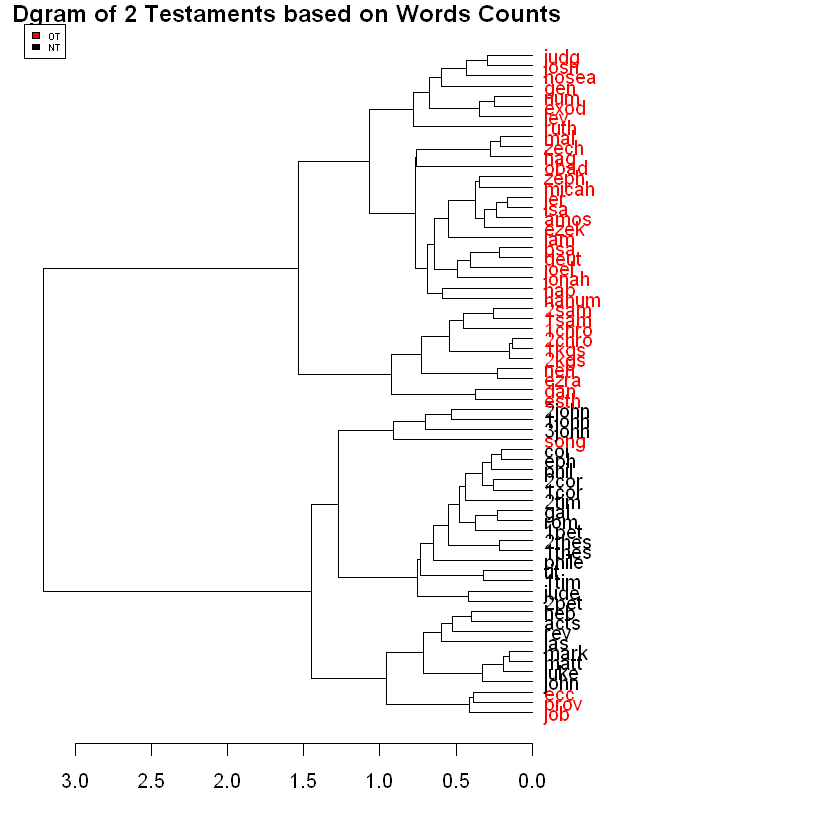

In [43]:
# For the two testaments based on the text of 66 books
# Utilizes wald linkage based on word counts
hclust_wald=hclust(as.dist(ASV_dm),'ward.D2')
dgram=as.dendrogram(hclust_wald)
labels_colors(dgram)<-as.numeric(as.factor(Testaments[hclust_wald$order]))
dgram<-set(dgram,"labels_cex",1.0)
par(mar=c(4,1,1,12))
plot(dgram,horiz = TRUE,main='Dgram of 2 Testaments based on Words Counts')
legend("topleft", cex=0.45, legend = unique(Testaments), fill = as.numeric(as.factor(unique(Testaments))))

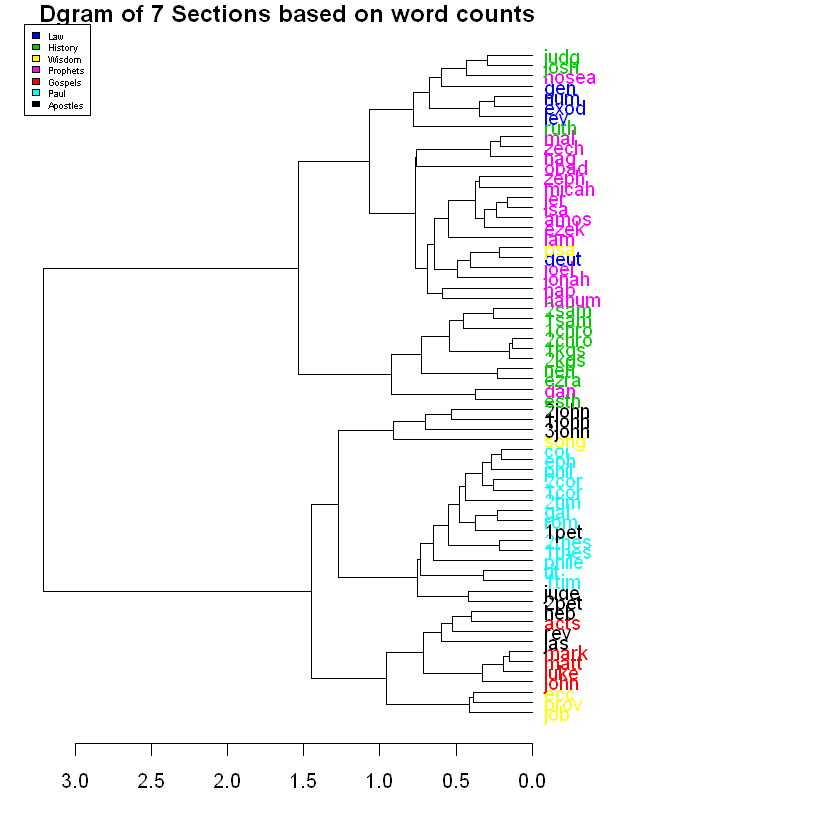

In [45]:
# For the seven levels of sections in the bible
# Utilizes wald linkage based on word counts
hclust_wald=hclust(as.dist(ASV_dm),'ward.D2')
dgram=as.dendrogram(hclust_wald)
labels_colors(dgram)<-as.numeric(as.factor(Sections[hclust_wald$order]))
dgram<-set(dgram,"labels_cex",1.0)
par(mar=c(4,1,1,12))
plot(dgram,horiz = TRUE,main='Dgram of 7 Sections based on word counts')
legend("topleft", cex=0.45, legend = unique(Sections), fill = as.numeric(as.factor(unique(Sections))))

## MDS plots:

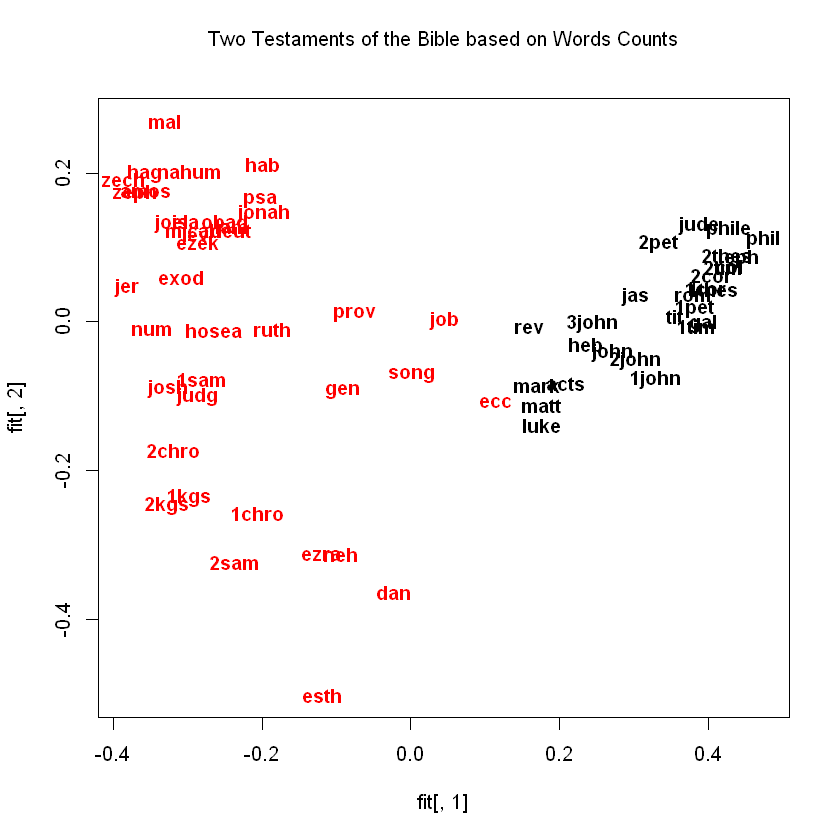

In [46]:
# For 2 testaments:
fit<-cmdscale(as.dist(ASV_dm),k=2)
plot(fit[,2]~fit[,1],type='n')
text(x = fit[,1], y = fit[,2], labels = row.names(fit), col=unclass(as.factor(Testaments)), cex=.95, font=2)
mtext( cex = 1, text = "Two Testaments of the Bible based on Words Counts", line=2,outer=FALSE)

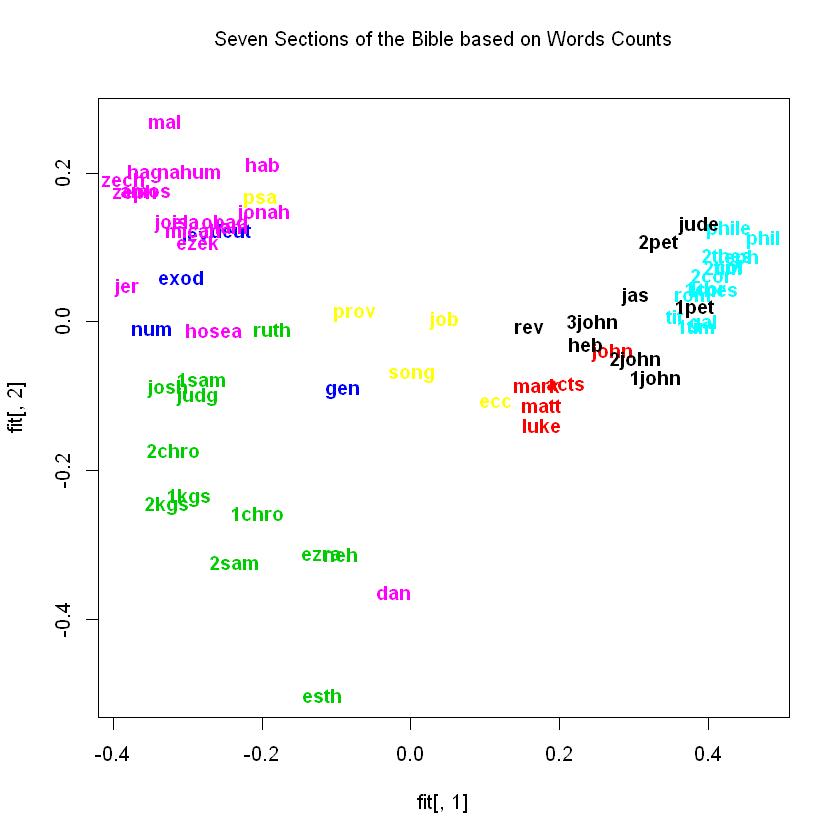

In [47]:
# For 7 sections:
fit<-cmdscale(as.dist(ASV_dm),k=2)
plot(fit[,2]~fit[,1],type='n')
text(x = fit[,1], y = fit[,2], labels = row.names(fit), col=unclass(as.factor(Sections)), cex=.95, font=2)
mtext( cex = 1, text = "Seven Sections of the Bible based on Words Counts", line=2,outer=FALSE)

From these graphics, we can see that the dendogram and MSD plots with the 2 clusters match with the two testaments. The dendogram and MSD plots with 7 clusters seemed to match with the 7 sections.


## Principle Component Analysis (PCA):

In [48]:
# Firstly the document term matrix file is transformed into a matrix
ASV_m<-as.matrix(ASV_dtm)
ASV_dtm.pca=prcomp(ASV_m) 
ASV_dtm.pca$rotation[1:5,1:5] #To display first 5 PC's
dim(ASV_dtm.pca$x)

,PC1,PC2,PC3,PC4,PC5
round_cut,-1.648058e-04,-0.0008648294,-0.0006715227,-0.0001366474,-7.600066e-05
jehovah_god_die,-4.146433e-04,0.0001636758,0.0004045446,-0.0003189592,2.579996e-04
worthy_unloose,2.809317e-05,0.0002548109,0.0002151326,0.0009181075,-8.116030e-04
saul_meet,-1.718941e-04,0.0009938088,-0.0004880269,0.0002247653,6.699454e-04
season_jesus,2.616924e-05,0.0003256117,0.0001408742,0.0008984095,-9.047611e-04


[1] 66 66

In [49]:
#To calculate standard deviation for each PC
ASV_dtm.sd=ASV_dtm.pca$sdev
ASV_dtm.var=ASV_dtm.pca$sdev^2 #To compute variance
ASV_dtm.var[1:5]
#Proportion of Variance
pvar=ASV_dtm.var/sum(ASV_dtm.var) 
cumsum(pvar[1:10])

[1] 62365.711 11599.182 11129.915  9067.942  7667.156

[1] 0.4374061 0.5187578 0.5968182 0.6604168 0.7141909 0.7504946 0.7811174
 [8] 0.8091771 0.8327983 0.8554135

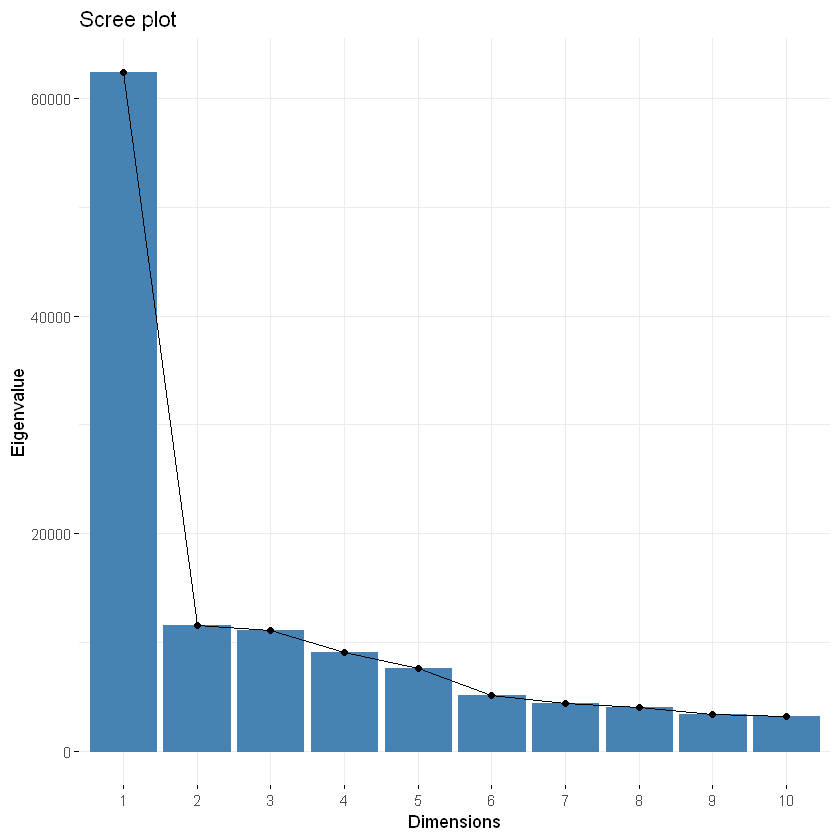

[1] 12

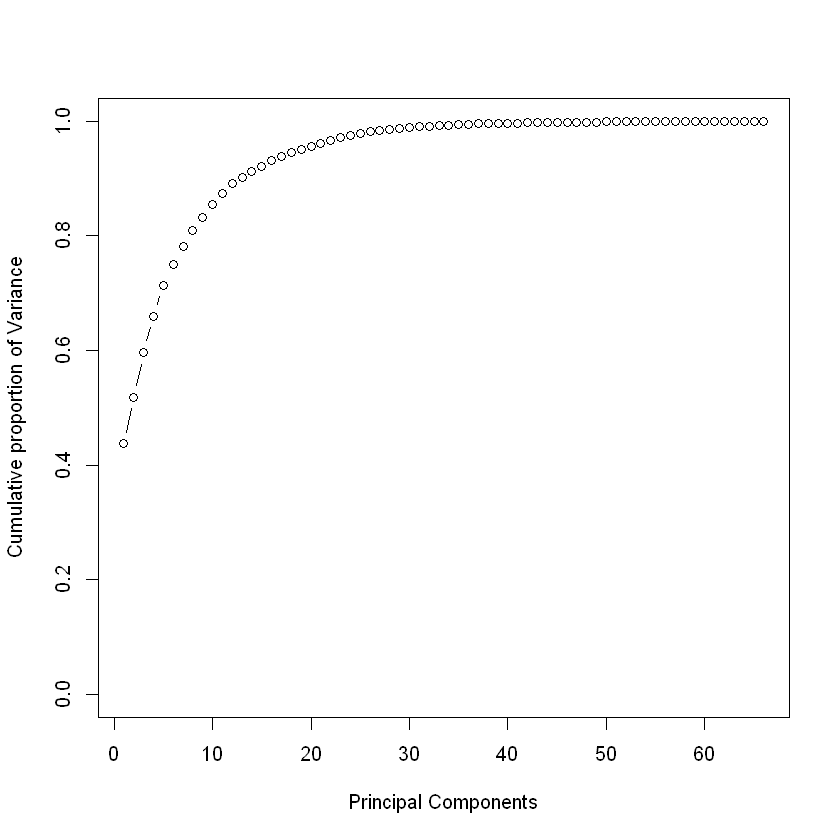

In [50]:
#Plotting the principal components based on the proportion of variance
fviz_screeplot(ASV_dtm.pca,np=10,choice="eigenvalue")
plot(cumsum(pvar),xlab="Principal Components", ylab="Cumulative proportion of Variance", ylim=c(0,1),type='b')
which.max(cumsum(pvar)[cumsum(pvar)<0.90])

These graphics indicate that 90% of variance is within 12 PC's. Therefore, the first 12 PC's were chosen for analysis.

In [52]:
ASV_dtmnew1=as.data.frame(ASV_dtm.pca$x[,1:12])
ASV_dtmnew2=ASV_dtm.pca$x[,1:12]

## K-Means:

In [59]:
# K=2, for testaments: 1- OT, 2- NT
set.seed(10)
ASV_km2.fit=kmeans(ASV_dtmnew1,2,nstart=50)
attributes(ASV_km2.fit)

$names
[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

$class
[1] "kmeans"

In [60]:
k2=table(ASV_km2.fit$cluster, ASV_test$Testaments)
k2

   
     1  2
  1 30 19
  2  9  8

[1] 0.5757576

[1] 0.4242424

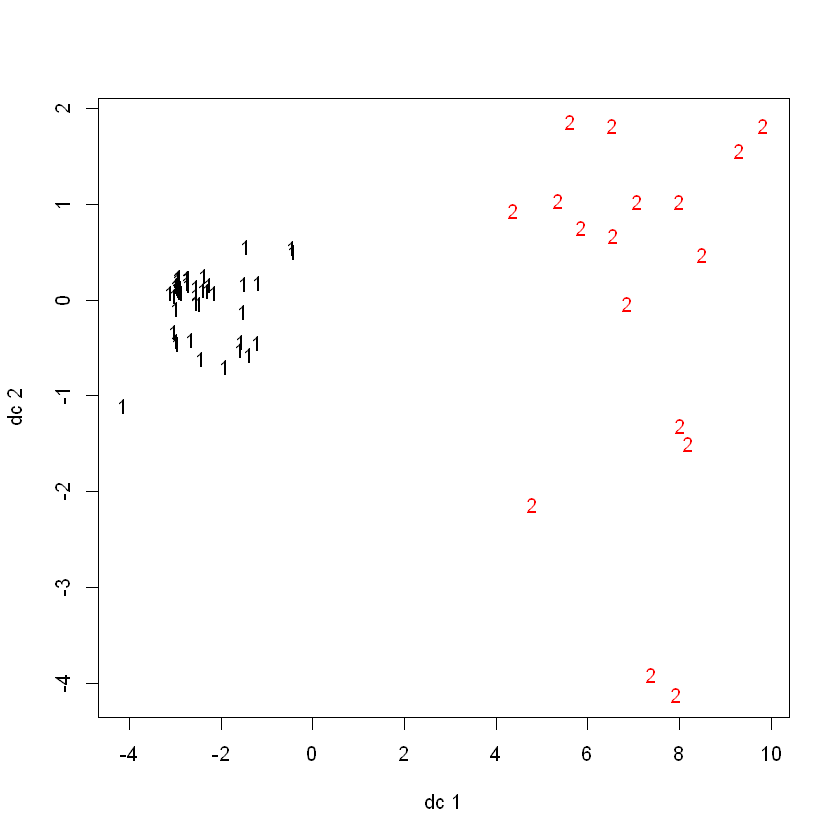

In [61]:
#Accuracy
mean(ASV_km2.fit$cluster==ASV_test$Testaments)
#Misclassification rate
misclassrate_km2<-1-sum(diag(k2))/sum(k2) 
misclassrate_km2
#Centroid plot 
plotcluster(ASV_dtmnew1,ASV_km2.fit$cluster)

In [68]:
# K=7, for sections: 1- Apostles, 2- Gospels, 3- History, 4- Law, 5- Paul, 6- Prophets, 7- Wisdom
set.seed(5)
ASV_km7.fit=kmeans(ASV_dtmnew1,7,nstart=50)
attributes(ASV_km7.fit)

$names
[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

$class
[1] "kmeans"

In [70]:
k7=table(ASV_km7.fit$cluster, ASV_s$Sections)
k7

   
    Apostles Gospels History Law Paul Prophets Wisdom
  1        1       0       0   0    0        1      0
  2        0       0       1   0    0        0      0
  3        0       0       0   1    1        0      1
  4        1       2       2   1    1        3      0
  5        4       3       4   3    8       13      4
  6        2       0       4   0    2        0      0
  7        1       0       1   0    1        0      0

[1] 0.01515152

[1] 0.9848485

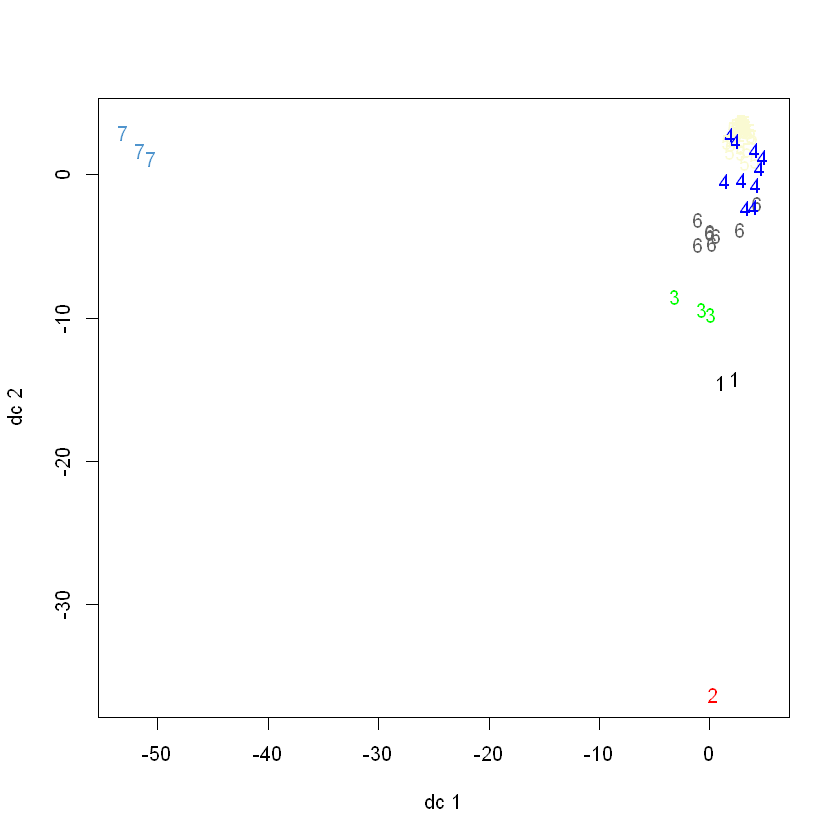

In [67]:
#Accuracy
mean(ASV_km7.fit$cluster==ASV_test$Testaments)
#Misclassification rate
misclassrate_km7<-1-sum(diag(k7))/sum(k7) 
misclassrate_km7
#Centroid plot
plotcluster(ASV_dtmnew1,ASV_km7.fit$cluster)

From these results, we can see that the misclassification rate is high for both testaments and sections. However, the misclassification rate seemed to be decreasing as we changed the set.seed value for k=2 alone. Hence, the misclassification rate is dependent upon the set.seed value for k=2.

## Fuzzy K-means:

### For K=2 (Testaments):

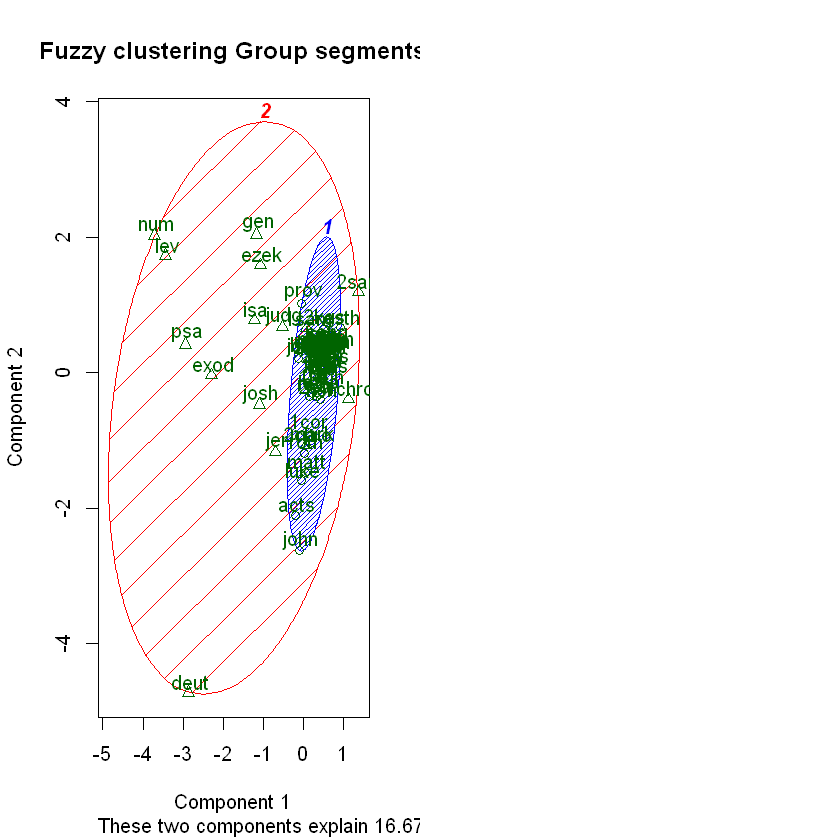

In [71]:
par(mfrow=c(1,2))
ASV_fkm2 <- cmeans(ASV_dtmnew1, 2, 100, m=2, method="cmeans")
clusplot(ASV_dtmnew1, ASV_fkm2$cluster, color=TRUE, shade=TRUE,
         labels=2, lines=0, main= 'Fuzzy clustering Group segments') # Segmentation representation (2D)

In [74]:
fkm2<-table(ASV_fkm2$cluster,ASV_test$Testaments) 
fkm2


   
     1  2
  1 30 19
  2  9  8

[1] 0.5757576

[1] 0.4242424

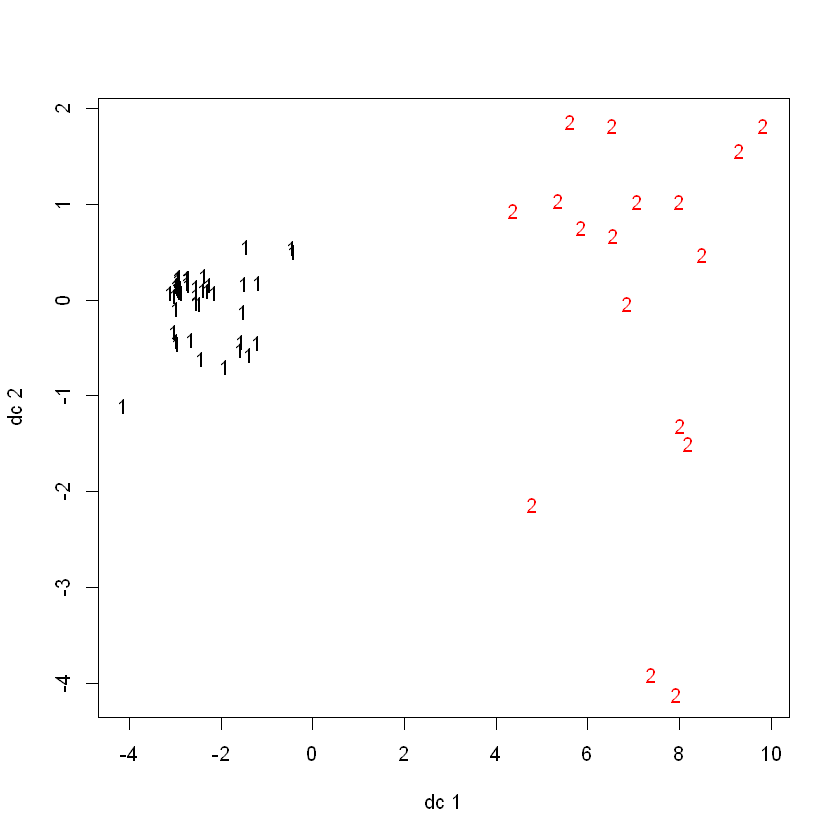

In [76]:
mean(ASV_fkm2$cluster ==ASV_test$Testaments) # Accuracy
misclassrate_fkm2<-1-sum(diag(fkm2))/sum(fkm2)  # Misclassification rate
misclassrate_fkm2
# Centroid Plot
plotcluster(ASV_dtmnew1, ASV_fkm2$cluster)

### For K=7 (Sections):

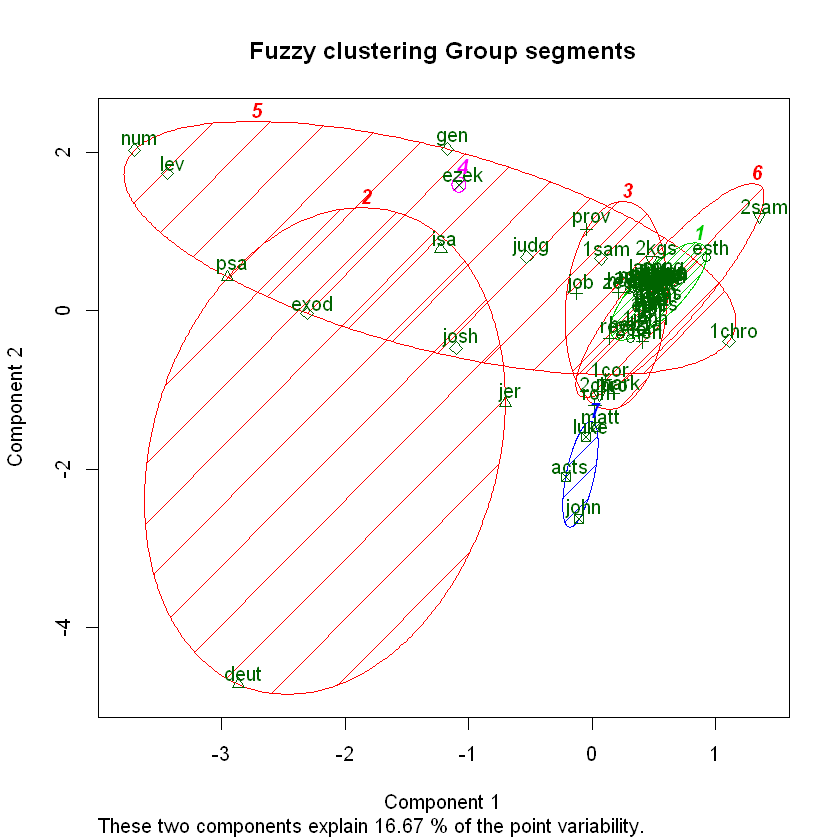

In [77]:
ASV_fkm7 <- cmeans(ASV_dtmnew1, 7, 100, m=2, method="cmeans")
clusplot(ASV_dtmnew1, ASV_fkm7$cluster, color=TRUE, shade=TRUE,
         labels=2, lines=0, main= 'Fuzzy clustering Group segments') # Segmentation representation (2D)

In [78]:
fkm7<-table(ASV_fkm7$cluster,ASV_s$Sections) 
fkm7

   
    Apostles Gospels History Law Paul Prophets Wisdom
  1        4       3       4   3    6       12      3
  2        1       0       0   0    1        1      1
  3        0       1       0   1    3        4      1
  4        0       0       0   1    0        0      0
  5        2       0       4   0    2        0      0
  6        1       0       2   0    1        0      0
  7        1       1       2   0    0        0      0

[1] 0

[1] 0.8939394

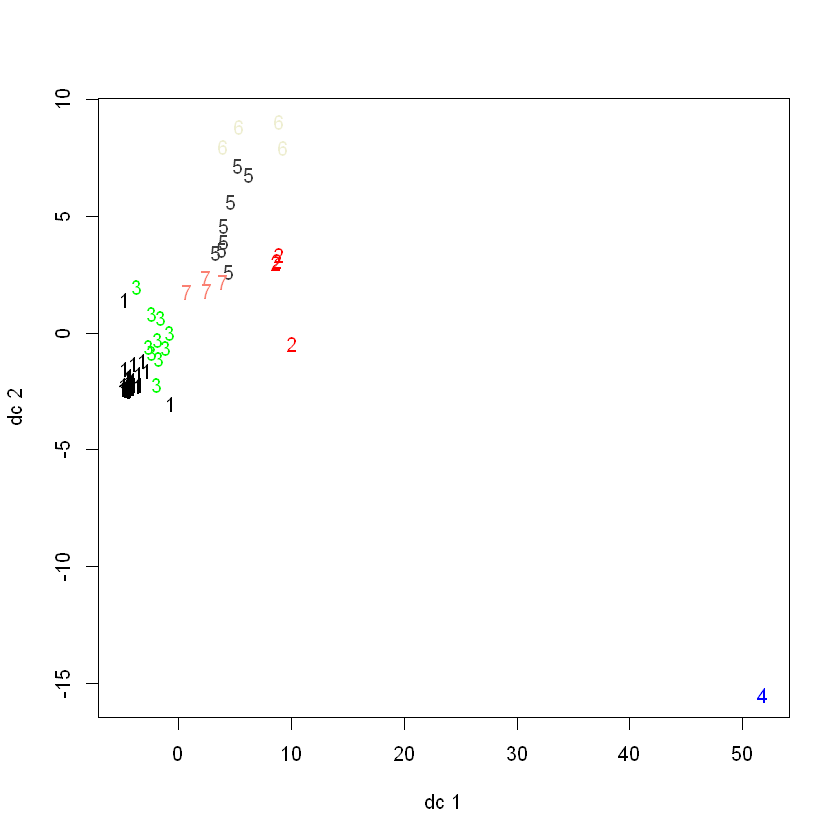

In [79]:
mean(ASV_fkm7$cluster ==ASV_s$Sections) # Accuracy
misclassrate_fkm7<-1-sum(diag(fkm7))/sum(fkm7)  # Misclassification rate
misclassrate_fkm7
# Centroid Plot
plotcluster(ASV_dtmnew1, ASV_fkm7$cluster)

From these results we can see that the misclassification rate for Fuzzy k-means clustering is high for the 2 testaments and 7 sections as well.

## Hierarchical clustering:

In [84]:
par(mfrow=c(1,2))

### For K=2 (Testaments)

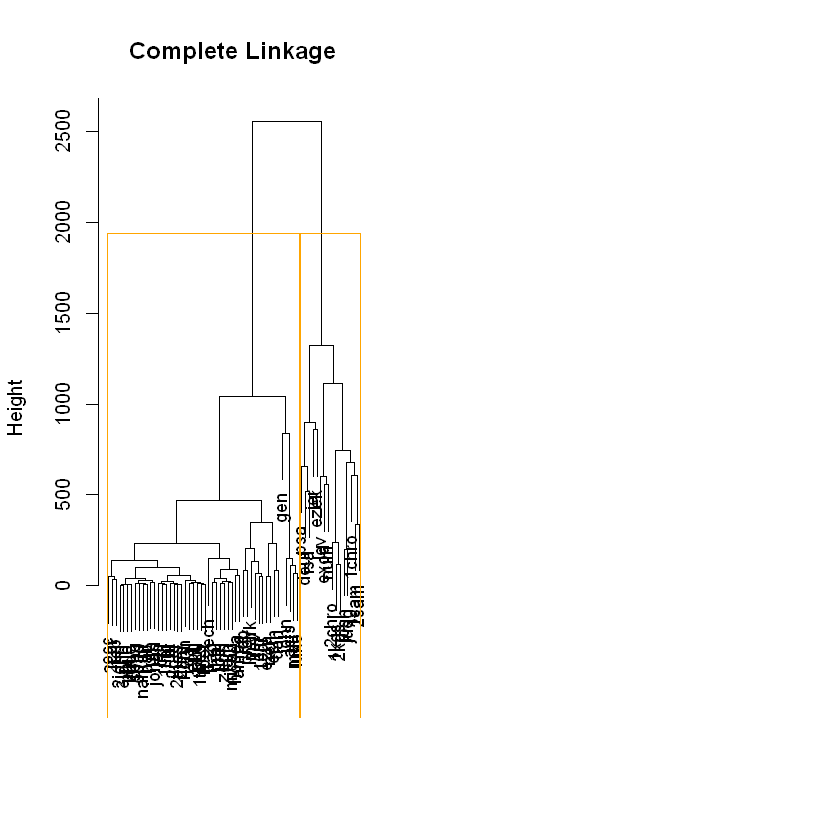

In [83]:
ASV_hc_ward=hclust(dist(ASV_dtmnew1, method = "euclidean"), method="ward.D2")
plot(ASV_hc_ward,main="Complete Linkage", xlab="", sub="", cex=.9) # Dendrogram
rect.hclust(ASV_hc_ward,k=2,border="Orange") # Bordering the dendogram around two clusters


    
hc_2  1  2
   1 31 19
   2  8  8

[1] 0.5909091

[1] 0.4090909

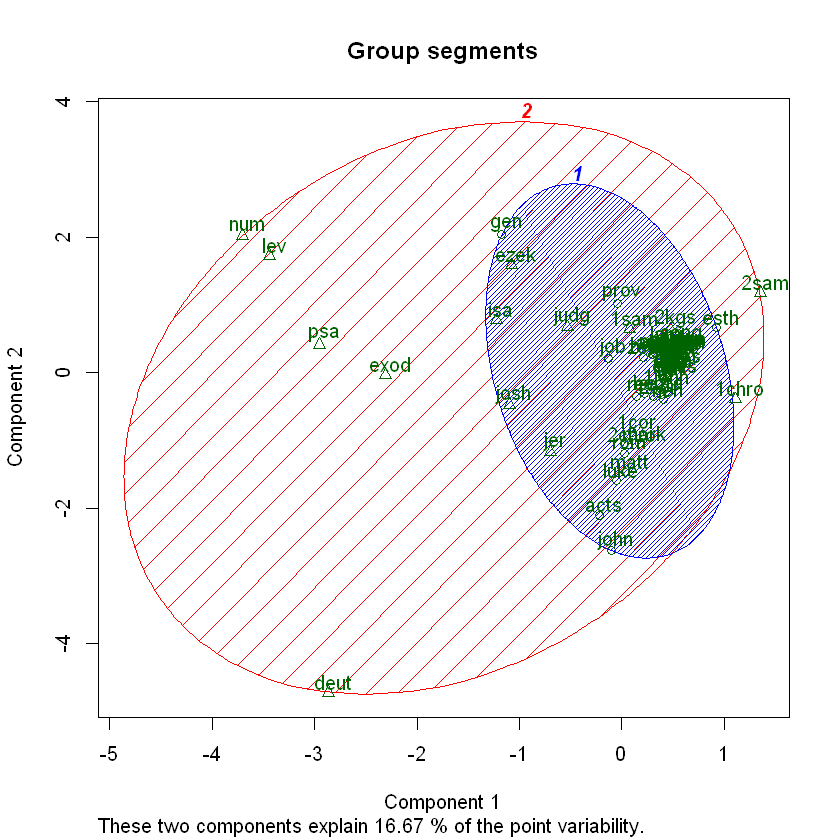

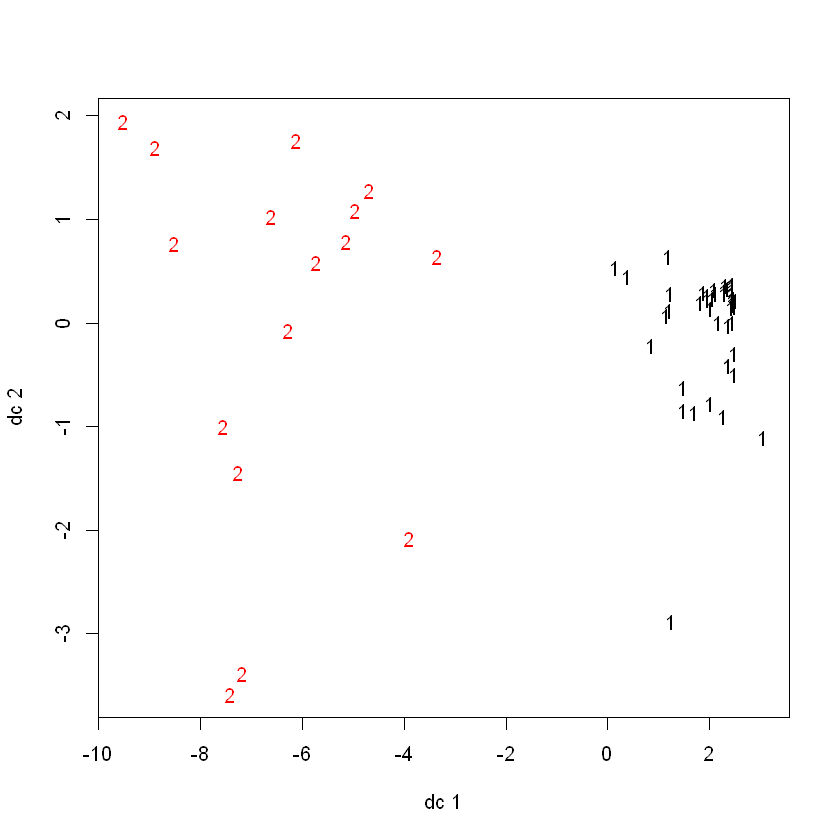

In [82]:
hc_2=cutree(ASV_hc_ward,2)
hc2<-table(hc_2,ASV_test$Testaments) 
hc2
mean(hc_2 ==ASV_test$Testaments) # Accuracy
misclassrate_hc2<-1-sum(diag(hc2))/sum(hc2) 
misclassrate_hc2 # Misclassification rate
# 2D representation of the Segmentation:
clusplot(ASV_dtmnew1, hc_2, color=TRUE, shade=TRUE,
         labels=2, lines=0, main= 'Group segments')
# Centroid Plot 
plotcluster(ASV_dtmnew1, hc_2)

In [ ]:
plot(hc.ward,main="Complete Linkage", xlab="", sub="", cex=.9)
# draw dendogram with red borders around the 2 clusters
rect.hclust(hc.ward,k=7,border="red")
groups7=cutree(hc.ward,7)# cut tree into 5 clusters
#Accuracy and misclassification rate
y_h7<-table(groups7,bible_bs$Sections) ;y_h7
mean(groups7 ==bible_bs$Sections)
misrate_h7<-1-sum(diag(y_h7))/sum(y_h7)  ; misrate_h7
# 2D representation of the Segmentation:
clusplot(dtm_bnew, groups7, color=TRUE, shade=TRUE,
         labels=2, lines=0, main= 'Group segments')
# Centroid Plot against 1st 2 discriminant functions
plotcluster(dtm_bnew, groups7)

### For K=7 (Sections)

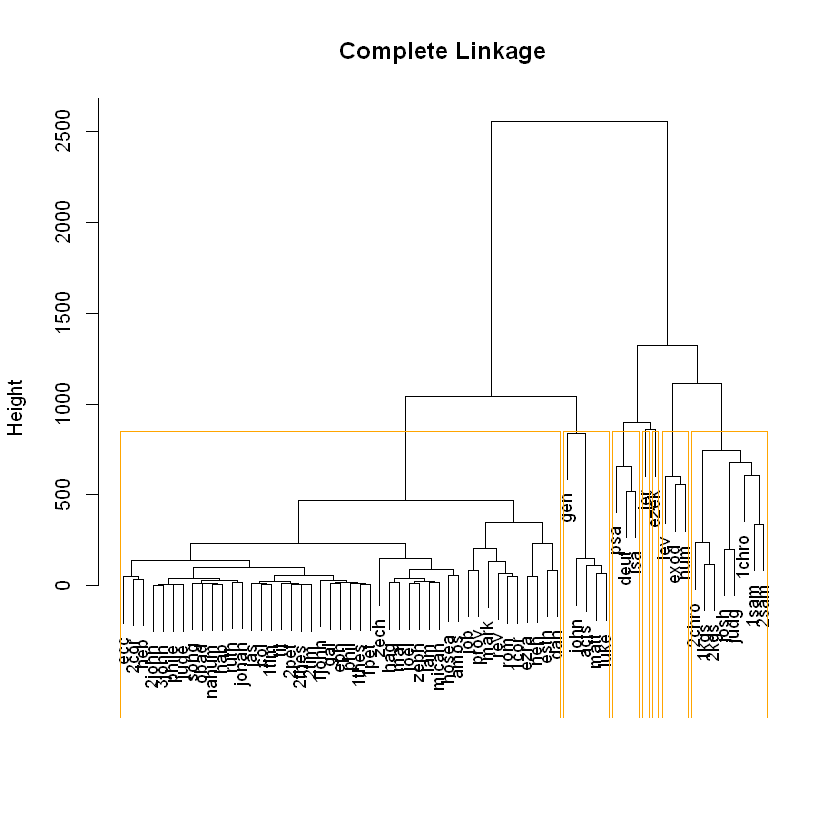

In [86]:
plot(ASV_hc_ward,main="Complete Linkage", xlab="", sub="", cex=.9) # Dendrogram
rect.hclust(ASV_hc_ward,k=7,border="Orange") # Bordering the dendogram around two clusters


    
hc_7 Apostles Gospels History Law Paul Prophets Wisdom
   1        1       1       3   0    0        0      0
   2        1       0       1   0    1        0      0
   3        1       0       0   0    0        1      1
   4        2       0       4   0    2        0      0
   5        4       4       4   4    9       16      4
   6        0       0       0   0    1        0      0
   7        0       0       0   1    0        0      0

[1] 0

[1] 0.8484848

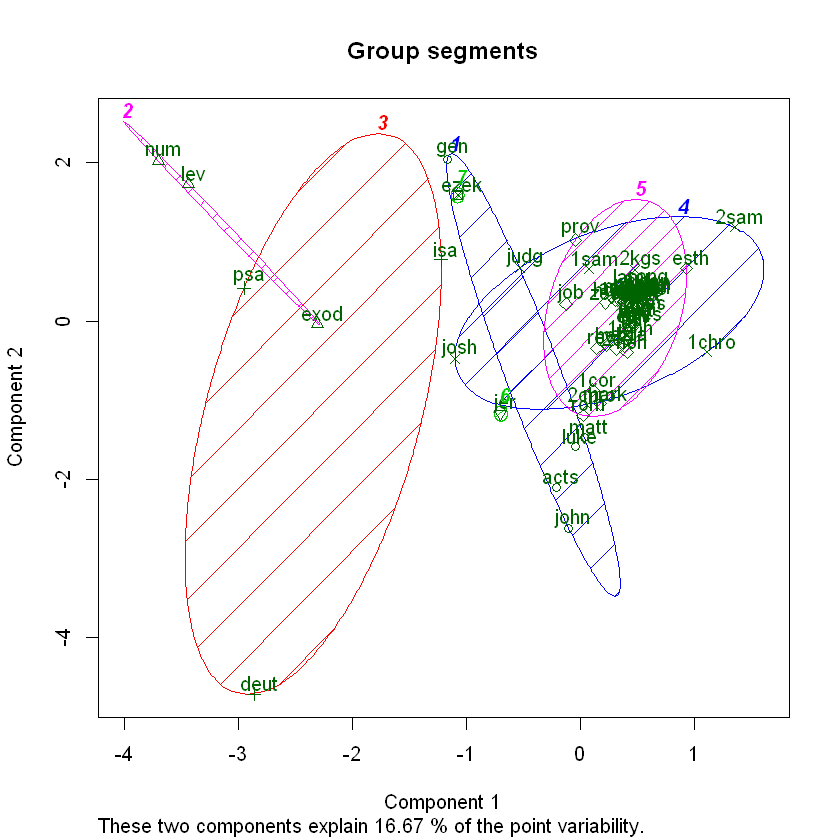

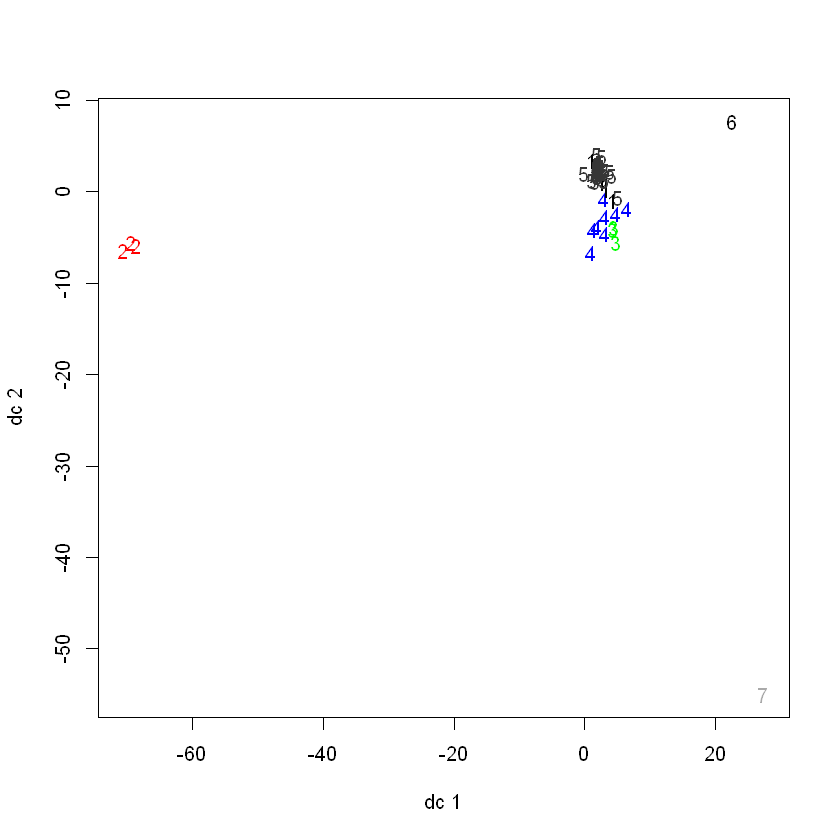

In [87]:
hc_7=cutree(ASV_hc_ward,7)
hc7<-table(hc_7,ASV_s$Sections) 
hc7
mean(hc_7 ==ASV_s$Sections) # Accuracy
misclassrate_hc7<-1-sum(diag(hc7))/sum(hc7) 
misclassrate_hc7 # Misclassification rate
# 2D representation of the Segmentation:
clusplot(ASV_dtmnew1, hc_7, color=TRUE, shade=TRUE,
         labels=2, lines=0, main= 'Group segments')
# Centroid Plot 
plotcluster(ASV_dtmnew1, hc_7)

From these results we can see that the misclassification rate for Fuzzy hierarchical clustering is high for the 2 testaments and 7 sections as well.

## NbClust

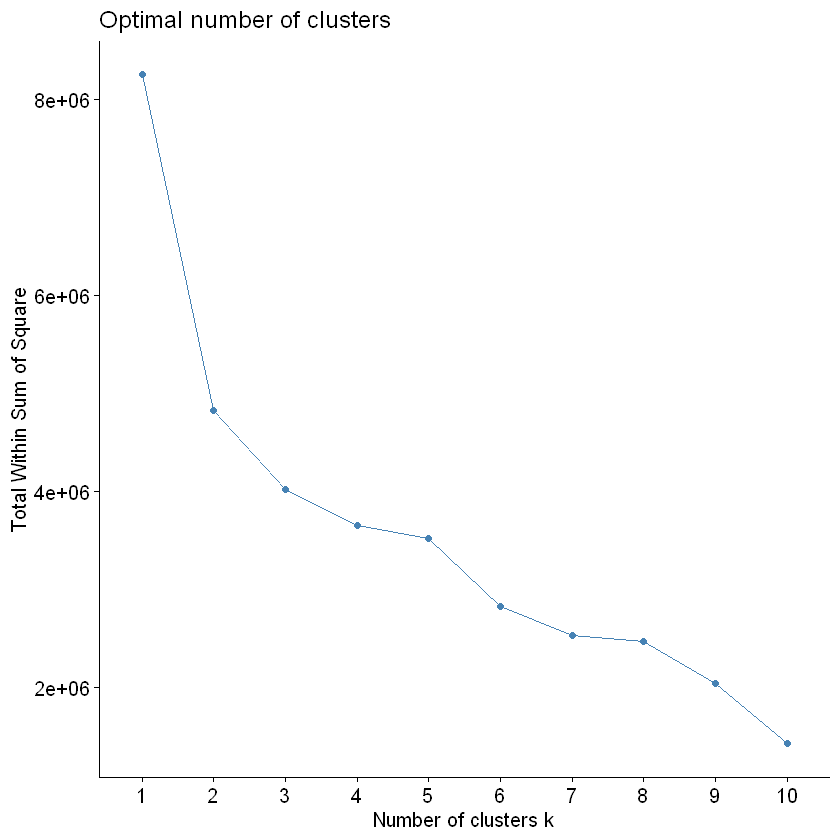

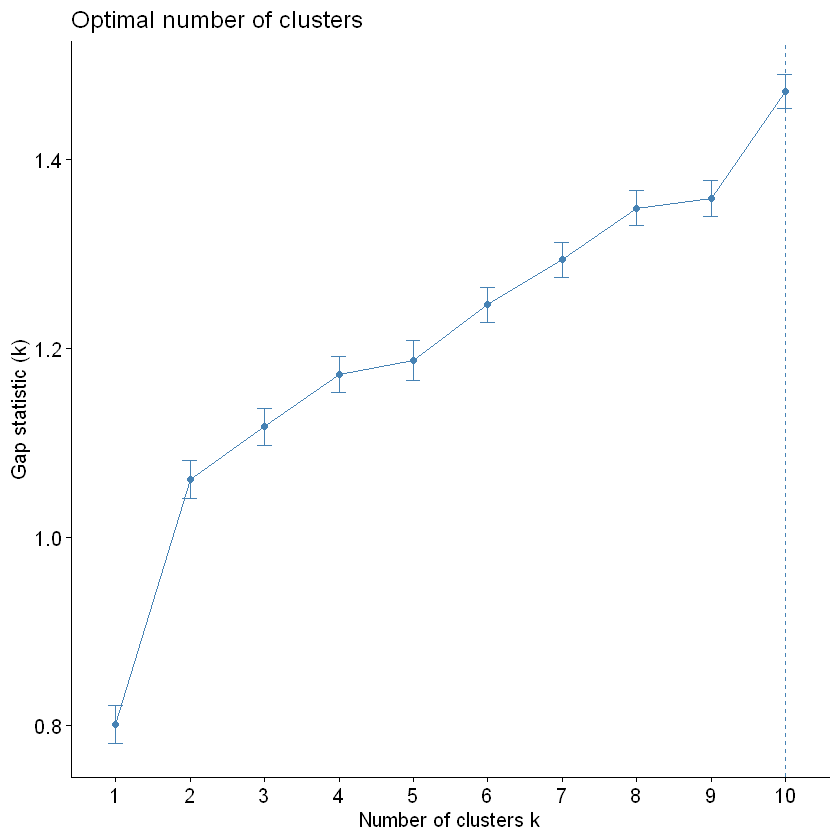

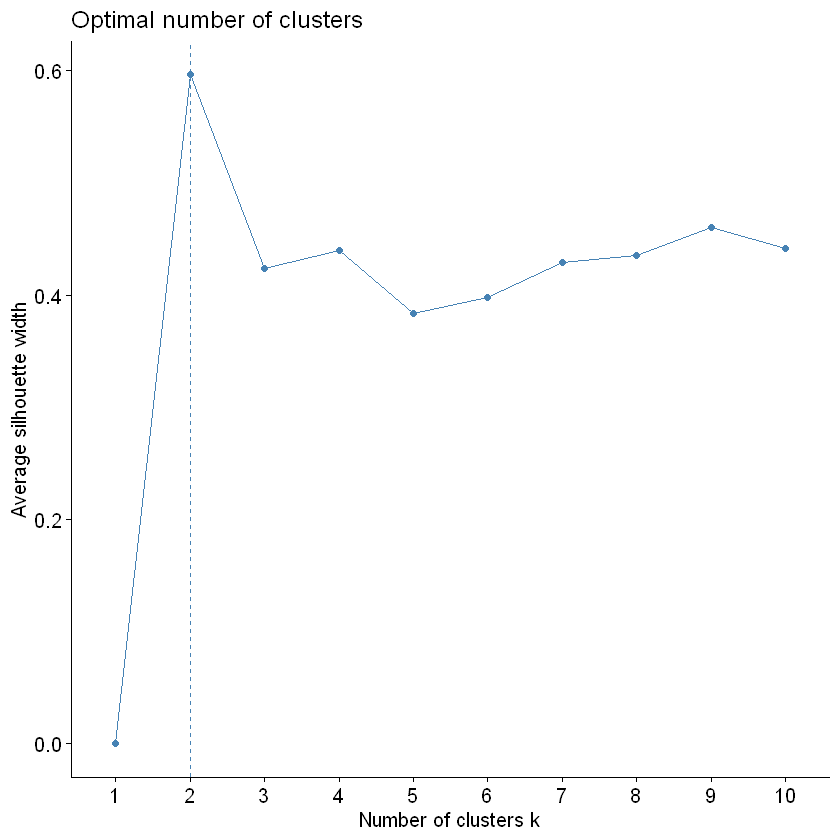

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


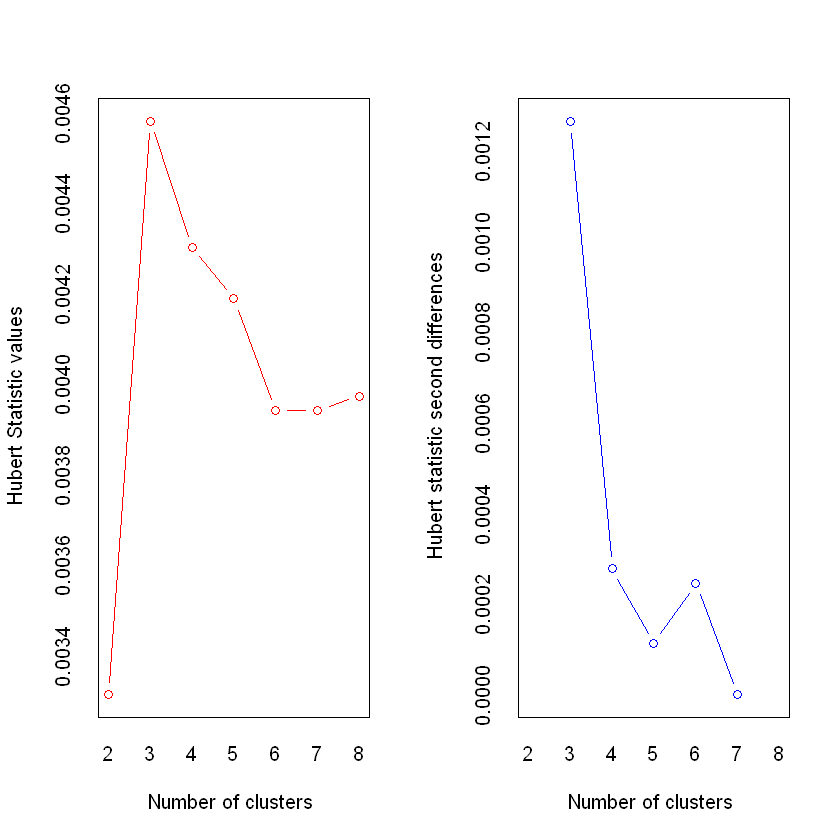

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 9 proposed 2 as the best number of clusters 
* 3 proposed 3 as the best number of clusters 
* 2 proposed 4 as the best number of clusters 
* 1 proposed 6 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 8 proposed 8 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
******************************************************************* 


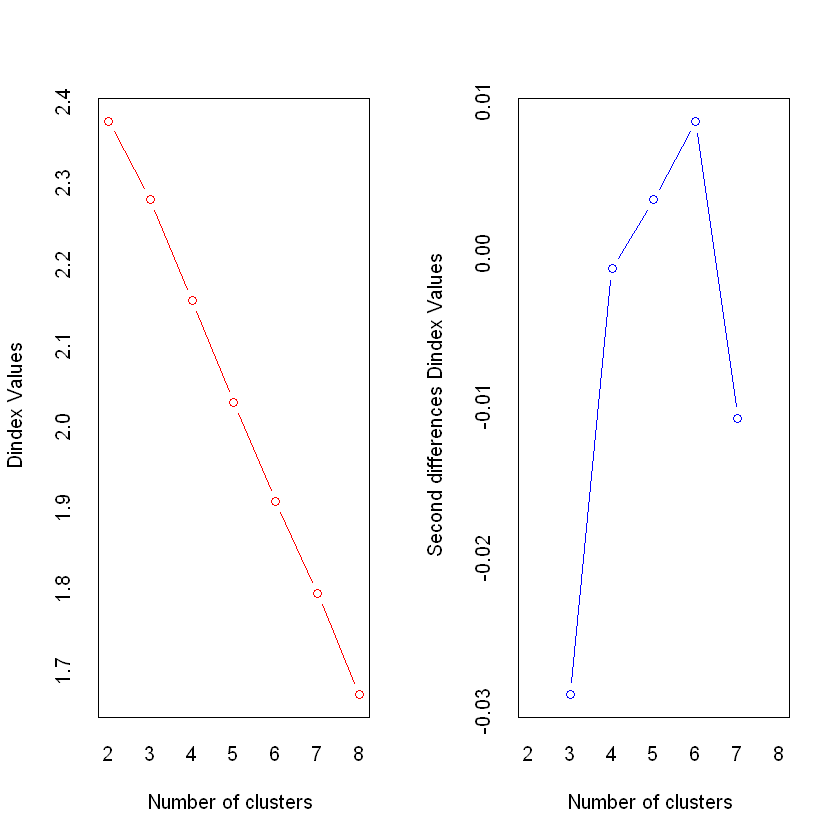

In [88]:
# Wss, gap statistic, silhouette and Nbclust was used to find the optimal number of clusters
par(mfrow=c(2,2))
fviz_nbclust(ASV_dtmnew2,kmeans,method="wss") 
fviz_nbclust(ASV_dtmnew2,kmeans,method="gap_stat") 
fviz_nbclust(ASV_dtmnew2,kmeans,method="silhouette") 
ASV.nbclust<-ASV_dtmnew2 %>%
  scale() %>%
  NbClust(distance="euclidean",min.nc=2,max.nc=8,method="complete",index="all")

This analysis suggests that 2 is the optimal number of clusters based on the majority rule.

## Model Based Clustering

In [89]:
par(mfrow=c(1,2))
mbc_fit <- Mclust(ASV_dtmnew1)
summary(mbc_fit) # To display the best model
mbc_fit$modelName 
mbc_fit$G  

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEI (diagonal, equal shape) model with 6 components: 

 log.likelihood  n df       BIC       ICL
      -3479.037 66 94 -7351.902 -7352.688

Clustering table:
 1  2  3  4  5  6 
14 19  3 10 15  5 

[1] "VEI"

[1] 6

From the results, we can see that the optimal number of clusters are 6 under the VEI model, after conducting model based clustering. 

Too few points to calculate an ellipse


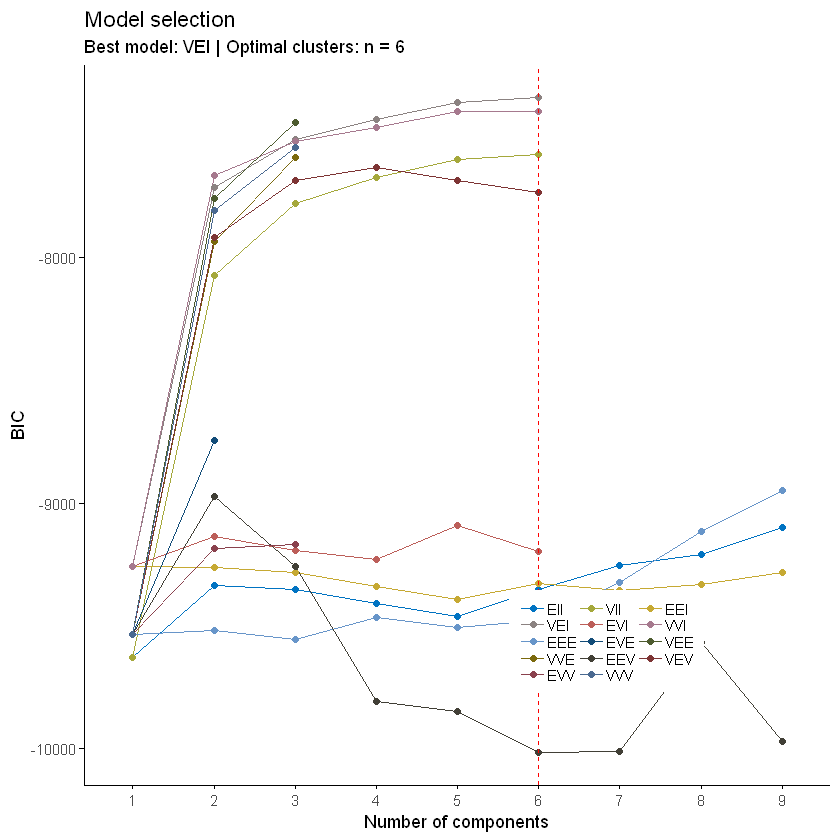

Too few points to calculate an ellipse


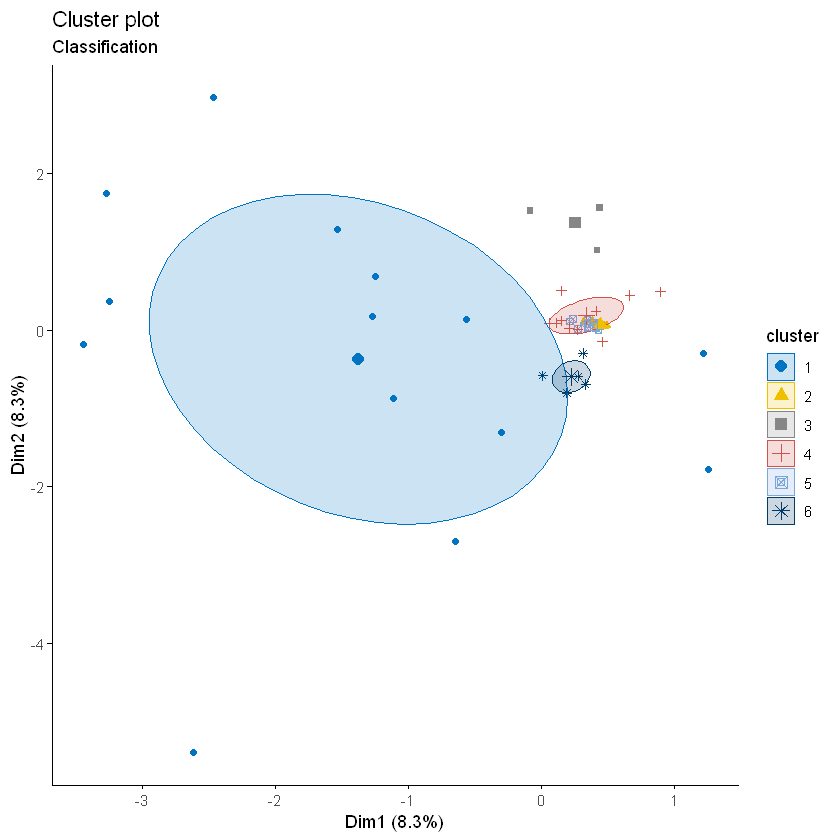

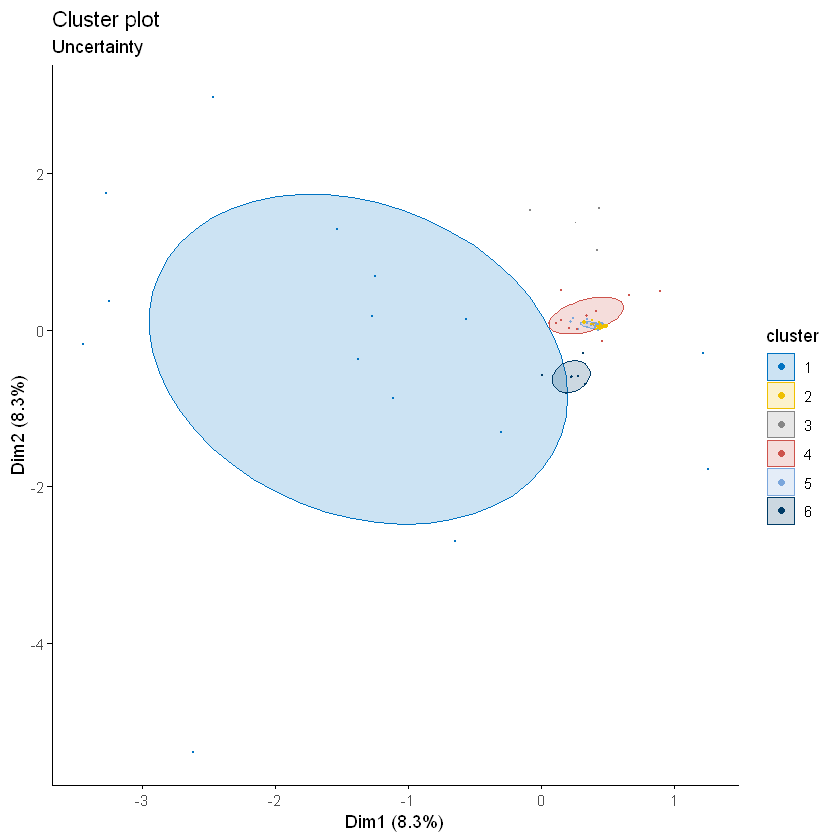

In [90]:
# BIC values used for choosing the number of clusters
fviz_mclust(mbc_fit, "BIC", palette = "jco")
# Classification: plot showing the clustering
fviz_mclust(mbc_fit, "classification", geom = "point", pointsize = 1.5, palette = "jco")
# Classification uncertainty
fviz_mclust(mbc_fit, "uncertainty", palette = "jco")

From the results, we can see that the optimal number of clusters are 6 under the VEI model, after conducting model based clustering. Having 2 or 7 clusters generated high misclassification rates. 

## Misclassification rates:

In [91]:
# For 2 Testaments
error_2 <- rbind(misclassrate_km2,misclassrate_fkm2, misclassrate_hc2)
rownames(error_2) <- (c('Kmeans Clustering','Fuzzy Clustering','Hierarchical Clustering'))
colnames(error_2) <- 'Error_rate2' ; 
round(error_2, 4)

,Error_rate2
Kmeans Clustering,0.4242
Fuzzy Clustering,0.4242
Hierarchical Clustering,0.4091


In [92]:
# For 7 Sections
error_7 <- rbind(misclassrate_km7,misclassrate_fkm7, misclassrate_hc7)
rownames(error_7) <- (c('Kmeans Clustering','Fuzzy Clustering','Hierarchical Clustering'))
colnames(error_7) <- 'Error_rate7' ; 
round(error_7, 4)

,Error_rate7
Kmeans Clustering,0.9848
Fuzzy Clustering,0.8939
Hierarchical Clustering,0.8485


## Clustering groups:

In [95]:
ASV.grouped_sections<-data.frame(ASV_dtmnew1,ASV_km2.fit$cluster)
ASV.grouped_testaments<-data.frame(ASV_dtmnew1,ASV_km7.fit$cluster)

## Word frequencies:

The word frequencies are analysed by removing numbers, punctuations, stopwords, stemdocuments, etc.

In [99]:
# For 7 sections:
corpus1<-Corpus(VectorSource(ASV_st$text))
text_corpus1 <- tm_map(corpus1,removeWords,ASV_sw1)
text_corpus1 <- tm_map(corpus1,removeWords,ASV_sw2)
text_corpus1 <- tm_map(corpus1, stripWhitespace)
text_corpus1 <- tm_map(corpus1, content_transformer(tolower))
text_corpus1 <- tm_map(corpus1, removeWords, stopwords("english"))
text_corpus1 <- tm_map(corpus1, stemDocument)
text_corpus1 <- tm_map(corpus1, removeNumbers)
text_corpus1 <- tm_map(corpus1, removePunctuation)
ASV_dtm_new3<-DocumentTermMatrix(text_corpus1)
dim(ASV_dtm_new3)
ASV_dtm_new4<-removeSparseTerms(ASV_dtm_new3,sparse=0.95)
dim(ASV_dtm_new4)
ASV_dtm_new5 <-DocumentTermMatrix(text_corpus1, control=list(wordLengths=c(2, 20), bounds = list(global = c(2,45))))
dim(ASV_dtm_new5)


Warning message in tm_map.SimpleCorpus(corpus1, removeWords, ASV_sw1):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, removeWords, ASV_sw2):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, stemDocument):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, removeNumbers):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus1, removePunctuation):
"transformation drops documents"

[1] 30722 12765

[1] 30722    48

[1] 30722  7454

In [100]:
freq<-sort(colSums(as.matrix(ASV_dtm_new5)),decreasing = TRUE)
head(freq,10)
w_f<-data.frame(word=names(freq),freq=freq)
head(w_f) 
head(w_f,10)

nakedness     redeem appearance     eateth      apart     tables     vessel 
        58         56         56         55         54         54         52 
    salute    sockets     esther 
        52         52         52

,word,freq
nakedness,nakedness,58
redeem,redeem,56
appearance,appearance,56
eateth,eateth,55
apart,apart,54
tables,tables,54


,word,freq
nakedness,nakedness,58
redeem,redeem,56
appearance,appearance,56
eateth,eateth,55
apart,apart,54
tables,tables,54
vessel,vessel,52
salute,salute,52
sockets,sockets,52
esther,esther,52


Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"shepherds could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"distress could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"rehoboam could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"looking could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"witnesses could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"lions could not be fit on page. It will not be plotted."Warning message in wordc

"joash could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"distress could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"rehoboam could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"looking could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"weight could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"witnesses could not be fit on page. It will not be plotted."Warning message in wordcloud(names(freq), freq, min.freq = 20, max.words = 80, random.order = FALSE, :
"dwelleth could not be fit 

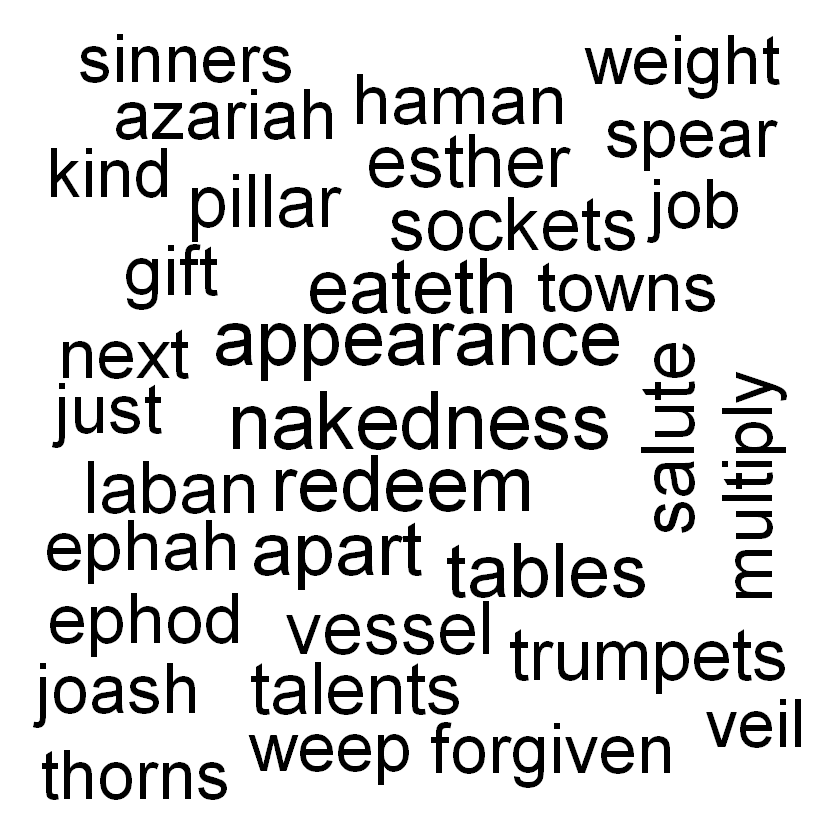

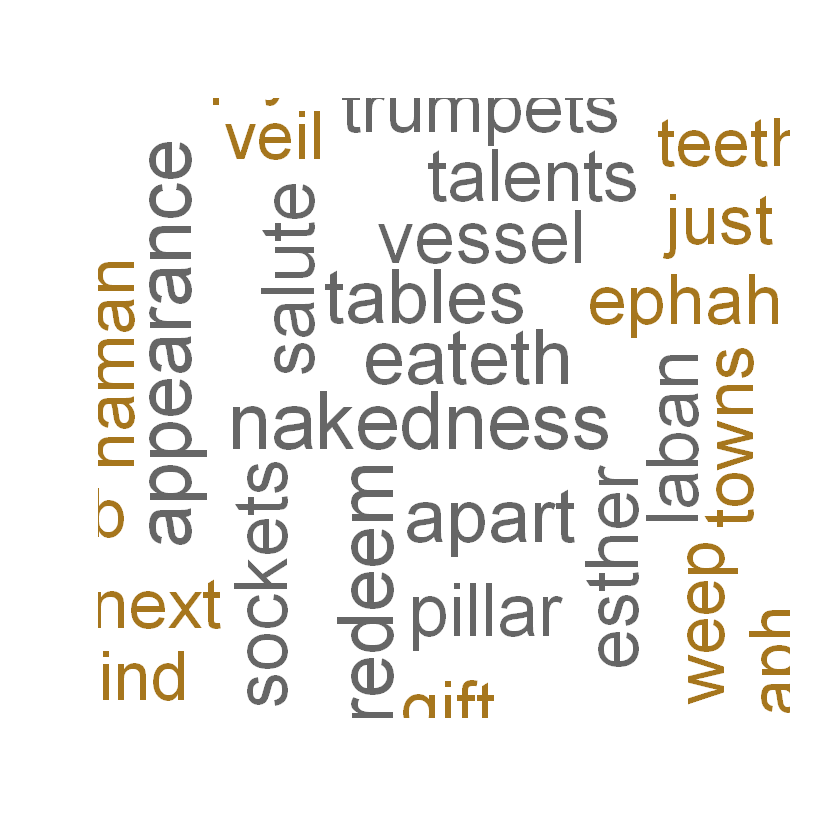

In [101]:
set.seed(129)
wordcloud(names(freq),freq,min.freq=20,max.words = 80,random.order = FALSE,rot.per = .1,
          random.color=TRUE)
wordcloud(names(freq),freq,min.freq=20,max.words = 80,random.order = FALSE,rot.per = .35,
          colors=brewer.pal(8,"Dark2"))

In [102]:
# For 66 books:
corpus2<-Corpus(VectorSource(ASV_Books$text))
text_corpus2 <- tm_map(corpus2,removeWords,ASV_sw1)
text_corpus2 <- tm_map(corpus2,removeWords,ASV_sw2)
text_corpus2 <- tm_map(corpus2, stripWhitespace)
text_corpus2 <- tm_map(corpus2, content_transformer(tolower))
text_corpus2 <- tm_map(corpus2, removeWords, stopwords("english"))
text_corpus2 <- tm_map(corpus2, stemDocument)
text_corpus2 <- tm_map(corpus2, removeNumbers)
text_corpus2 <- tm_map(corpus2, removePunctuation)
ASV_dtm_new6<-DocumentTermMatrix(text_corpus2)
dim(ASV_dtm_new6)
ASV_dtm_new7<-removeSparseTerms(ASV_dtm_new6,sparse=0.95)
dim(ASV_dtm_new7)
ASV_dtm_new8 <-DocumentTermMatrix(text_corpus2, control=list(wordLengths=c(4, 20), bounds = list(global = c(5,45))))
dim(ASV_dtm_new8) 

Warning message in tm_map.SimpleCorpus(corpus2, removeWords, ASV_sw1):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, removeWords, ASV_sw2):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, stemDocument):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, removeNumbers):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus2, removePunctuation):
"transformation drops documents"

[1]    66 27727

[1]   66 5269

[1]   66 3965

In [104]:
freq<-sort(colSums(as.matrix(ASV_dtm_new8)),decreasing = TRUE)
head(freq,15)
w_f<-data.frame(word=names(freq),freq=freq)
head(w_f) 
head(w_f,10)


jehovah      king    israel      land     david      pass     moses      took 
     5870      2166      2150      1579       972       843       769       751 
    jesus     judah   fathers jerusalem     spake     kings     thine 
      737       723       634       630       614       590       547

,word,freq
jehovah,jehovah,5870
king,king,2166
israel,israel,2150
land,land,1579
david,david,972
pass,pass,843


,word,freq
jehovah,jehovah,5870
king,king,2166
israel,israel,2150
land,land,1579
david,david,972
pass,pass,843
moses,moses,769
took,took,751
jesus,jesus,737
judah,judah,723


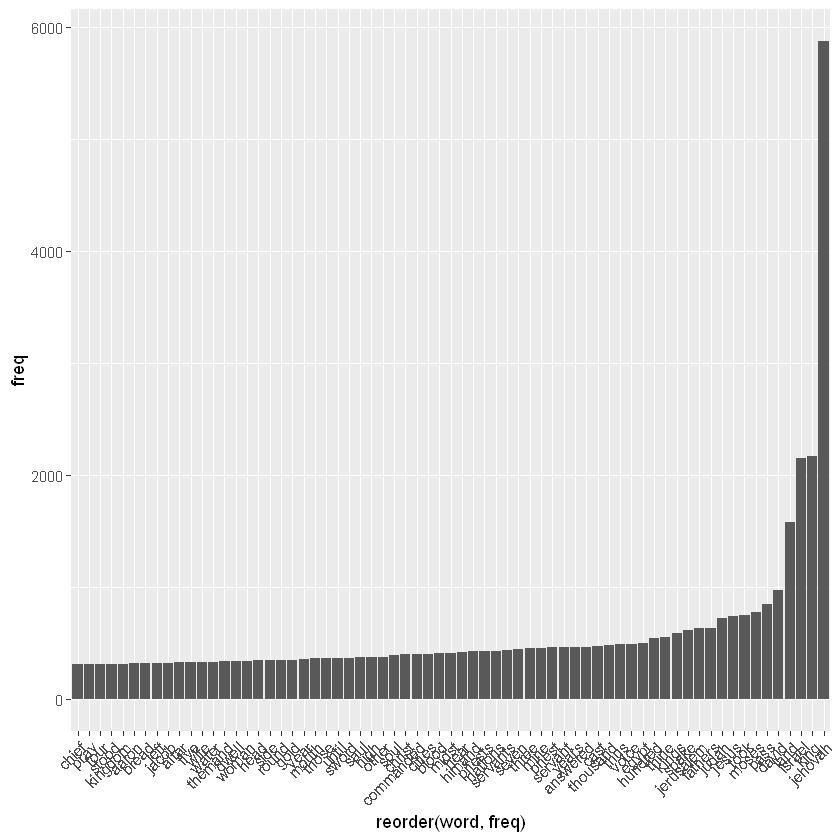

In [107]:
plot<-ggplot(subset(w_f,freq>300),aes(x=reorder(word,freq),y=freq))+geom_bar(stat="identity")+
            theme(axis.text.x=element_text(angle=45,hjust=1)) 
plot 

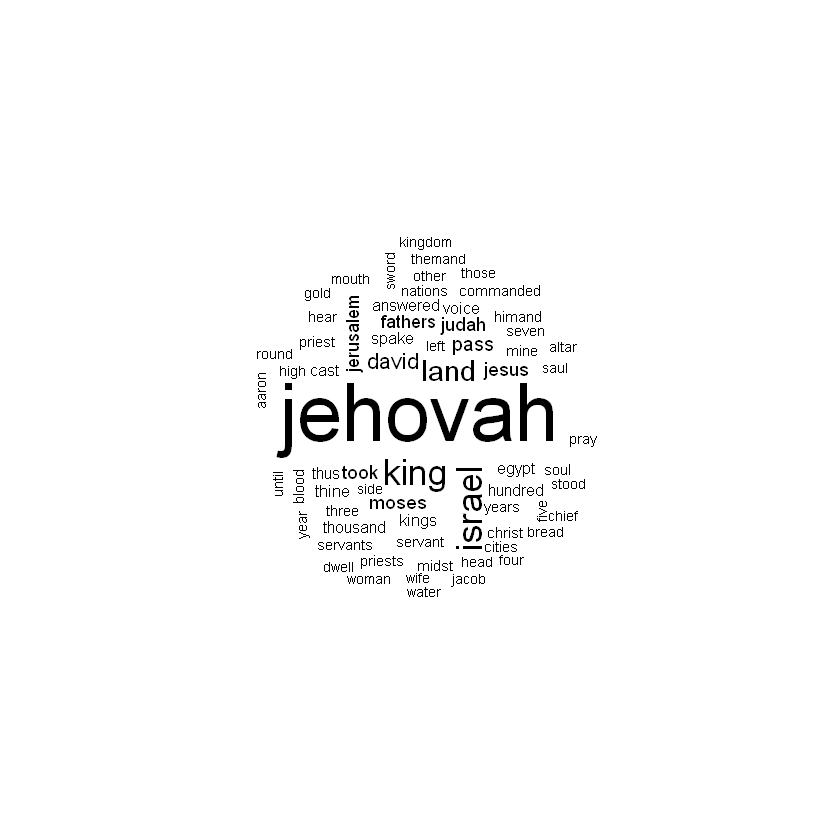

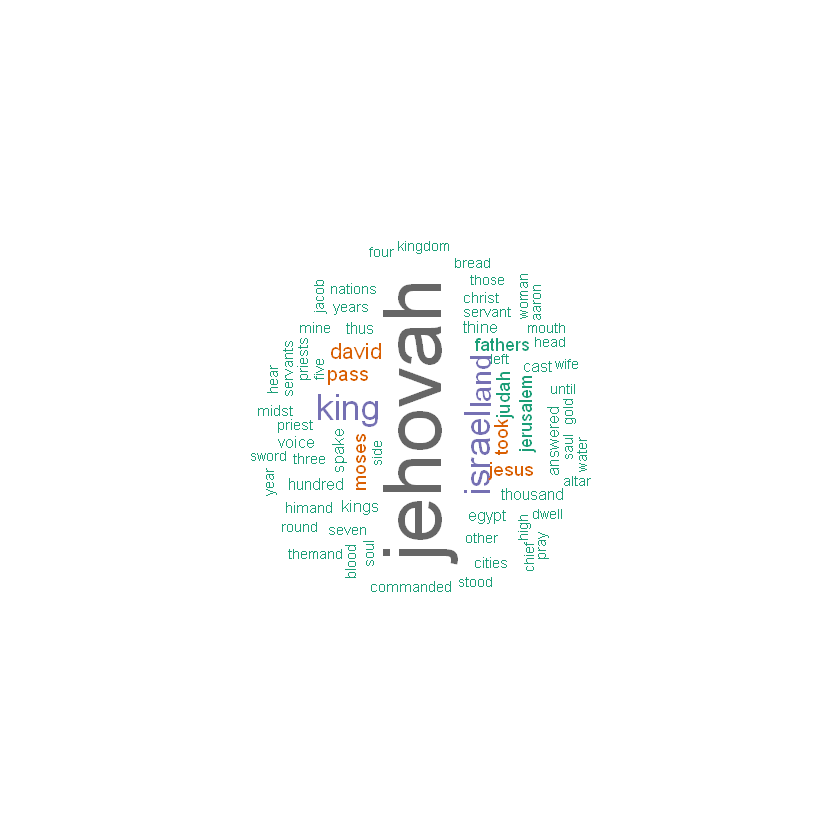

In [106]:
set.seed(129)
wordcloud(names(freq),freq,min.freq=300,max.words = 80,random.order = FALSE,rot.per = .1,
          random.color=TRUE)
wordcloud(names(freq),freq,min.freq=300,max.words = 80,random.order = FALSE,rot.per = .35,
          colors=brewer.pal(8,"Dark2"))

In [109]:
# For 2 testaments:
corpus3<-Corpus(VectorSource(ASV_tt$text))
text_corpus3 <- tm_map(corpus3,removeWords,ASV_sw1)
text_corpus3 <- tm_map(corpus3,removeWords,ASV_sw2)
text_corpus3 <- tm_map(corpus3, stripWhitespace)
text_corpus3 <- tm_map(corpus3, content_transformer(tolower))
text_corpus3 <- tm_map(corpus3, removeWords, stopwords("english"))
text_corpus3 <- tm_map(corpus3, stemDocument)
text_corpus3 <- tm_map(corpus3, removeNumbers)
text_corpus3 <- tm_map(corpus3, removePunctuation)
ASV_dtm_new9<-DocumentTermMatrix(text_corpus3)
dim(ASV_dtm_new9)
ASV_dtm_new10<-removeSparseTerms(ASV_dtm_new9,sparse=0.95)
dim(ASV_dtm_new10)
ASV_dtm_new11 <-DocumentTermMatrix(text_corpus3, control=list(wordLengths=c(4, 20), bounds = list(global = c(5,45))))
dim(ASV_dtm_new11) 

Warning message in tm_map.SimpleCorpus(corpus3, removeWords, ASV_sw1):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, removeWords, ASV_sw2):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, stemDocument):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, removeNumbers):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus3, removePunctuation):
"transformation drops documents"

[1] 30722 12765

[1] 30722    48

[1] 30722  3971

In [113]:
freq<-sort(colSums(as.matrix(ASV_dtm_new11)),decreasing = TRUE)
head(freq,20)
w_f<-data.frame(word=names(freq),freq=freq)
head(w_f) 
head(w_f,50)

nakedness     redeem appearance     eateth      apart     tables     vessel 
        58         56         56         55         54         54         52 
    salute    sockets     esther     pillar    talents   trumpets      laban 
        52         52         52         52         51         51         51 
     ephah       gift       next      haman      towns      ephod 
        50         50         50         50         50         50

,word,freq
nakedness,nakedness,58
redeem,redeem,56
appearance,appearance,56
eateth,eateth,55
apart,apart,54
tables,tables,54


,word,freq
nakedness,nakedness,58
redeem,redeem,56
appearance,appearance,56
eateth,eateth,55
apart,apart,54
tables,tables,54
vessel,vessel,52
salute,salute,52
sockets,sockets,52
esther,esther,52


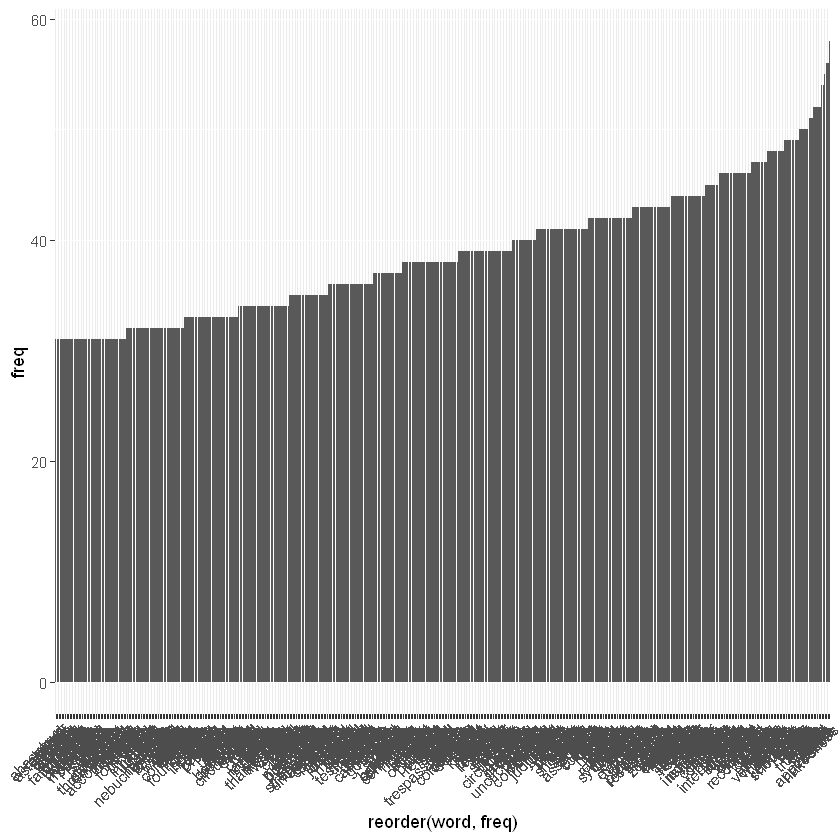

In [120]:
plot<-ggplot(subset(w_f,freq>30),aes(x=reorder(word,freq),y=freq))+geom_bar(stat="identity")+
            theme(axis.text.x=element_text(angle=45,hjust=1)) 
plot 

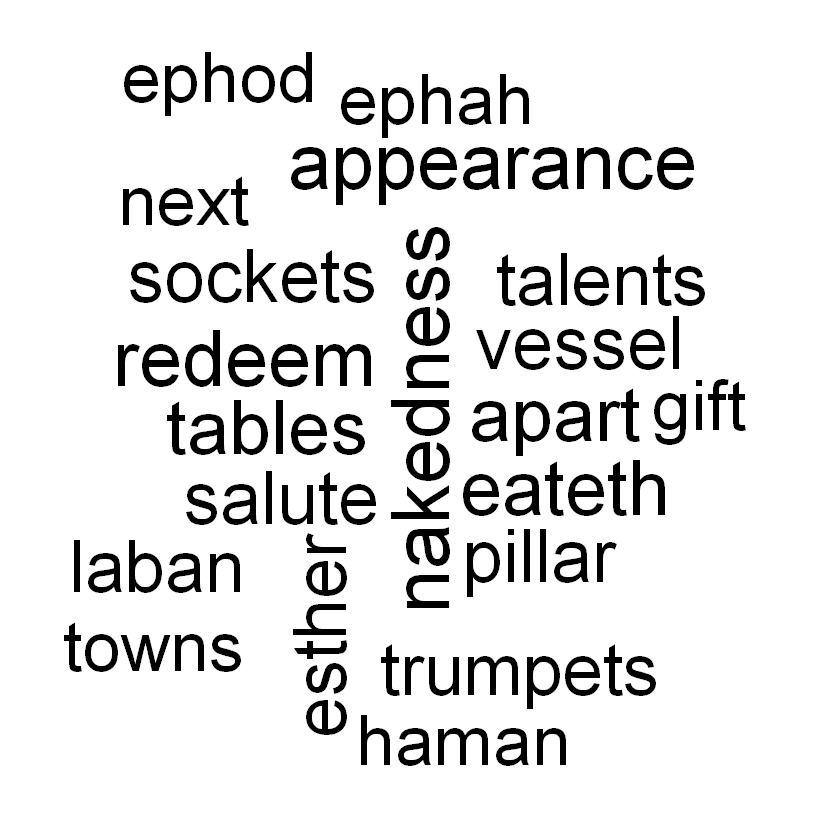

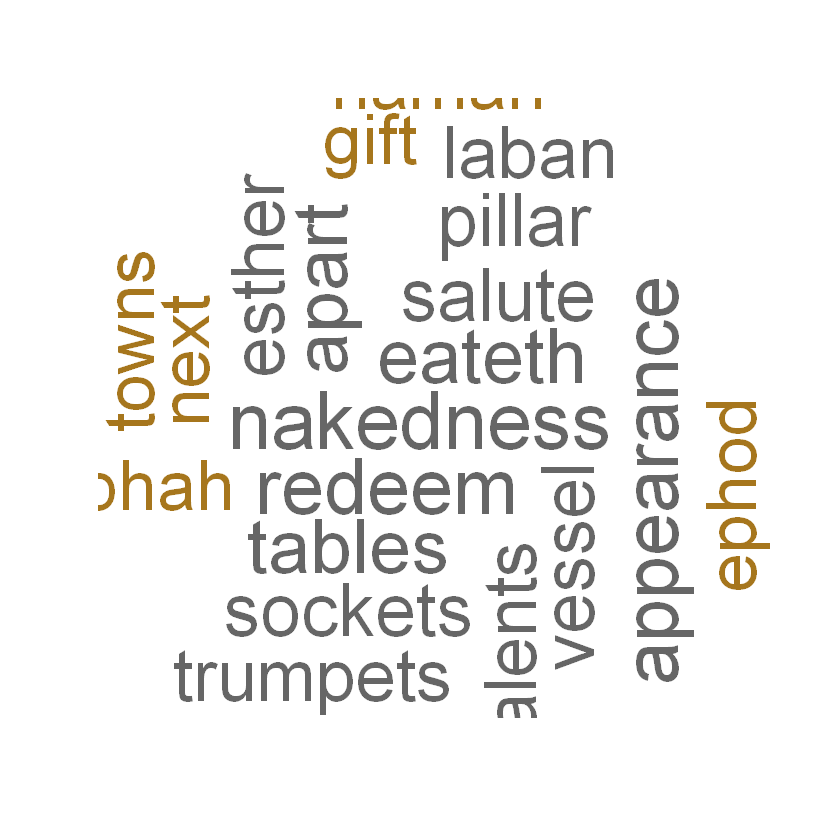

In [121]:
set.seed(129)
wordcloud(names(freq),freq,min.freq=5,max.words = 20,random.order = FALSE,rot.per = .1,
          random.color=TRUE)
wordcloud(names(freq),freq,min.freq=5,max.words = 20,random.order = FALSE,rot.per = .35,
          colors=brewer.pal(8,"Dark2"))

In [122]:
# For the entire dataset:
freq<-sort(colSums(as.matrix(ASV_dtm_new11)),decreasing = TRUE)
head(freq,20)
w_f<-data.frame(word=names(freq),freq=freq)
head(w_f)
head(w_f,50)


nakedness     redeem appearance     eateth      apart     tables     vessel 
        58         56         56         55         54         54         52 
    salute    sockets     esther     pillar    talents   trumpets      laban 
        52         52         52         52         51         51         51 
     ephah       gift       next      haman      towns      ephod 
        50         50         50         50         50         50

,word,freq
nakedness,nakedness,58
redeem,redeem,56
appearance,appearance,56
eateth,eateth,55
apart,apart,54
tables,tables,54


,word,freq
nakedness,nakedness,58
redeem,redeem,56
appearance,appearance,56
eateth,eateth,55
apart,apart,54
tables,tables,54
vessel,vessel,52
salute,salute,52
sockets,sockets,52
esther,esther,52


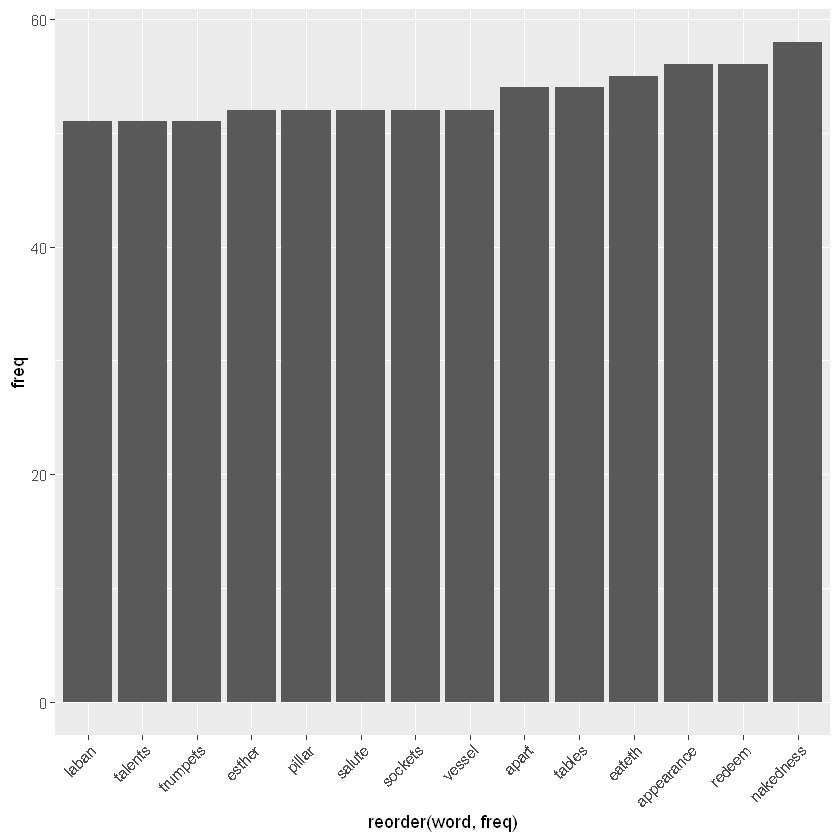

In [129]:
plot<-ggplot(subset(w_f,freq>50),aes(x=reorder(word,freq),y=freq))+geom_bar(stat="identity")+
            theme(axis.text.x=element_text(angle=45,hjust=1)) 
plot


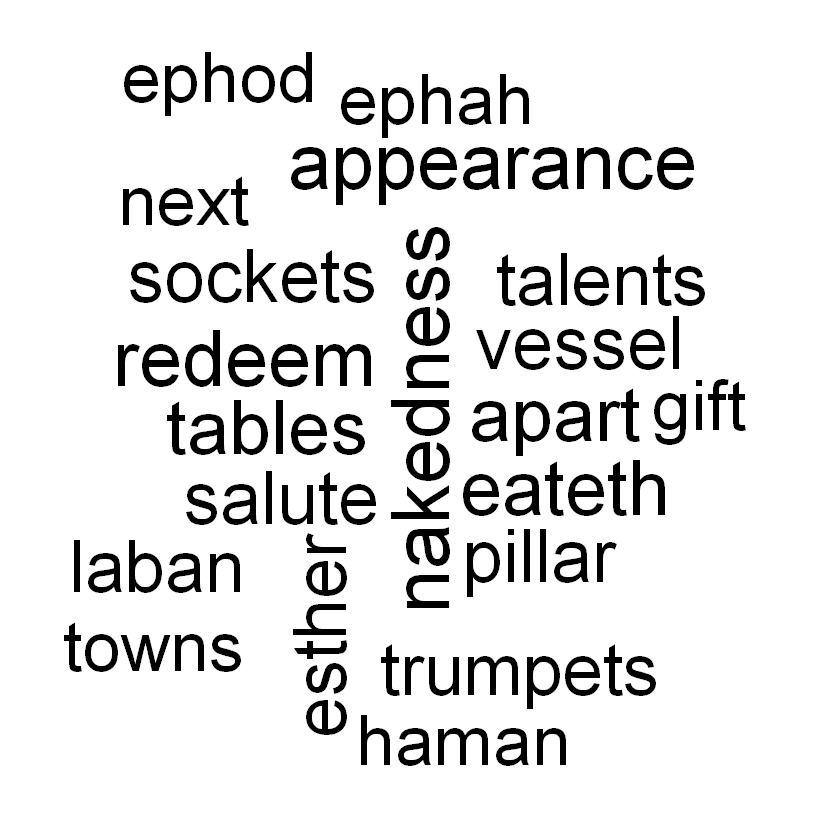

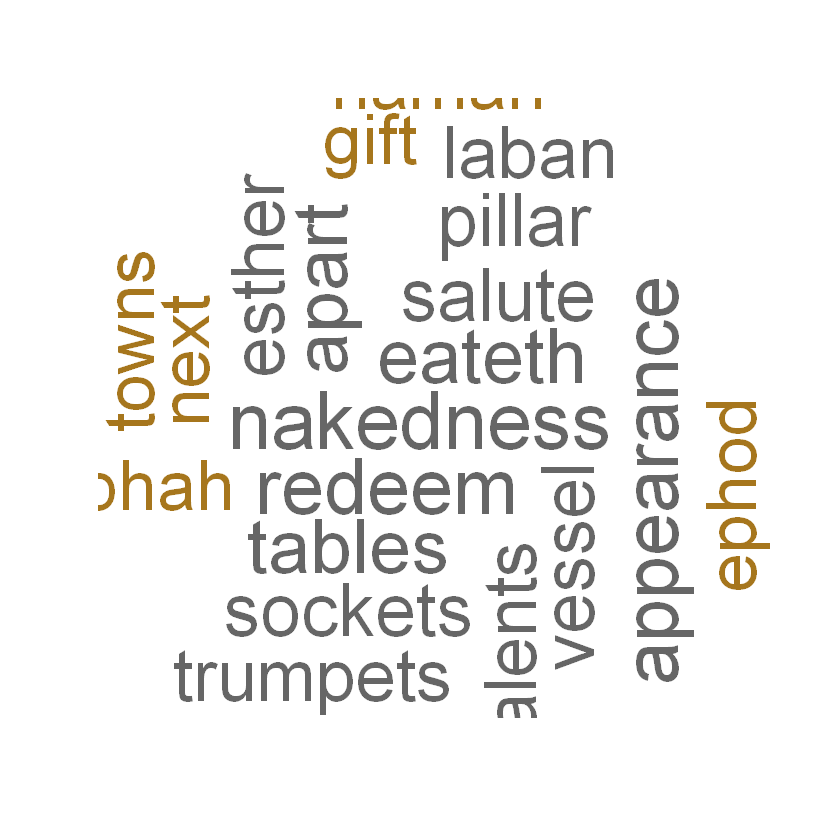

In [130]:
set.seed(129)
wordcloud(names(freq),freq,min.freq=1000,max.words = 20,random.order = FALSE,rot.per = .1,
          random.color=TRUE)
wordcloud(names(freq),freq,min.freq=1000,max.words = 20,random.order = FALSE,rot.per = .35,
          colors=brewer.pal(8,"Dark2"))

## Analysis of the given bible dataset:

In [131]:
#Analysis of the bible_book dataset 
corpus4<-Corpus(VectorSource(ASV_Books$text))
text_corpus4 <- tm_map(corpus4,removeWords,ASV_sw1)
text_corpus4 <- tm_map(corpus4,removeWords,ASV_sw2)
text_corpus4 <- tm_map(corpus4, stripWhitespace)
text_corpus4 <- tm_map(corpus4, content_transformer(tolower))
text_corpus4 <- tm_map(corpus4, removeWords, stopwords("english"))
text_corpus4 <- tm_map(corpus4, stemDocument)
text_corpus4 <- tm_map(corpus4, removeNumbers)
text_corpus4 <- tm_map(corpus4, removePunctuation)
ASV_dtm_new12<-DocumentTermMatrix(text_corpus4)
dim(ASV_dtm_new12)
ASV_dtm_new13<-removeSparseTerms(ASV_dtm_new12,sparse=0.95)
dim(ASV_dtm_new13)
ASV_dtm_new14 <-DocumentTermMatrix(text_corpus4, control=list(wordLengths=c(2, 20), bounds = list(global = c(2,45))))
dim(ASV_dtm_new14)


Warning message in tm_map.SimpleCorpus(corpus4, removeWords, ASV_sw1):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, removeWords, ASV_sw2):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, stripWhitespace):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, content_transformer(tolower)):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, removeWords, stopwords("english")):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, stemDocument):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, removeNumbers):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus4, removePunctuation):
"transformation drops documents"

[1]    66 27727

[1]   66 5269

[1]    66 10230

In [132]:
freq<-sort(colSums(as.matrix(ASV_dtm_new14)),decreasing = TRUE)
head(freq,25)
w_f<-data.frame(word=names(freq),freq=freq)
head(w_f)
head(w_f,20)


jehovah      king    israel      land     david       she      pass       two 
     5870      2166      2150      1579       972       966       843       805 
    moses      took     jesus     judah   fathers jerusalem     spake     kings 
      769       751       737       723       634       630       614       590 
      saw     thine   hundred       art     egypt      thus     voice  thousand 
      561       547       541       495       492       487       487       477 
     cast 
      474

,word,freq
jehovah,jehovah,5870
king,king,2166
israel,israel,2150
land,land,1579
david,david,972
she,she,966


,word,freq
jehovah,jehovah,5870
king,king,2166
israel,israel,2150
land,land,1579
david,david,972
she,she,966
pass,pass,843
two,two,805
moses,moses,769
took,took,751


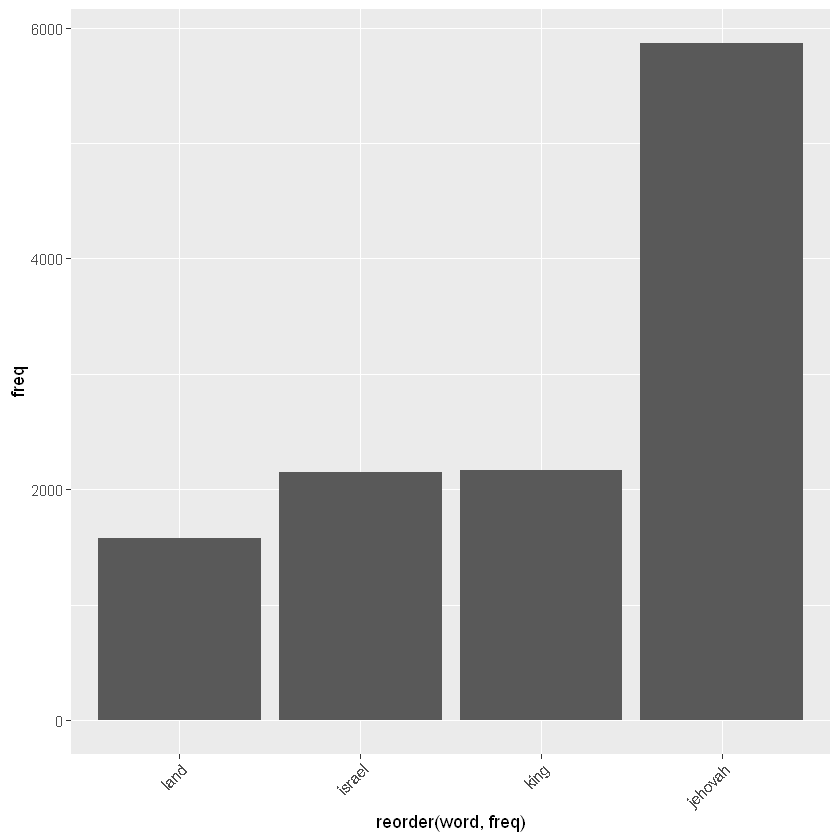

In [133]:
plot<-ggplot(subset(w_f,freq>1000),aes(x=reorder(word,freq),y=freq))+geom_bar(stat="identity")+
            theme(axis.text.x=element_text(angle=45,hjust=1)) 
plot

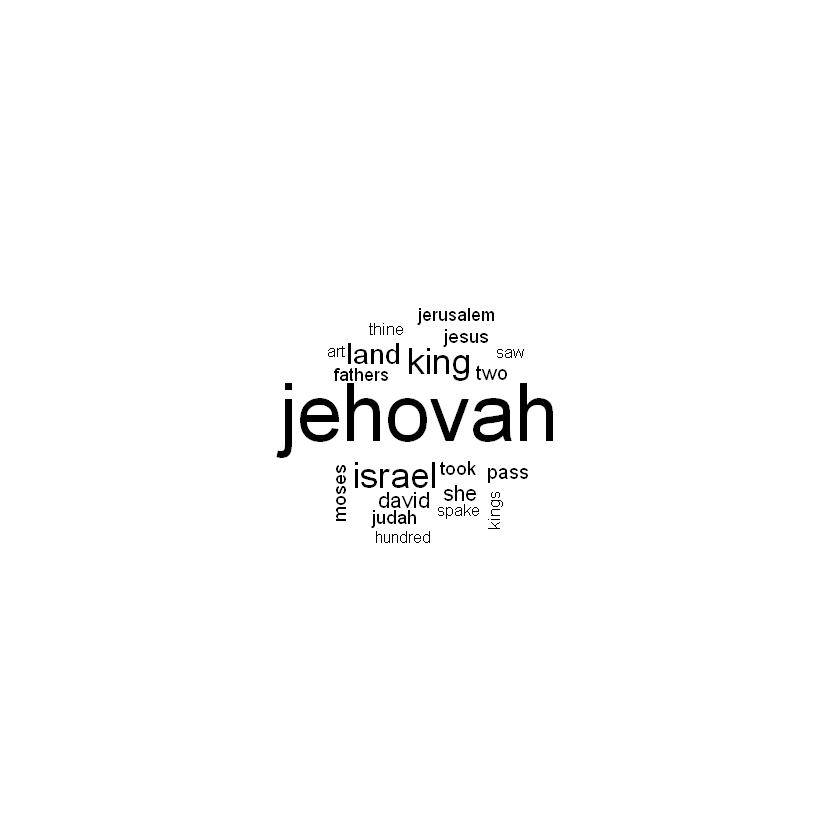

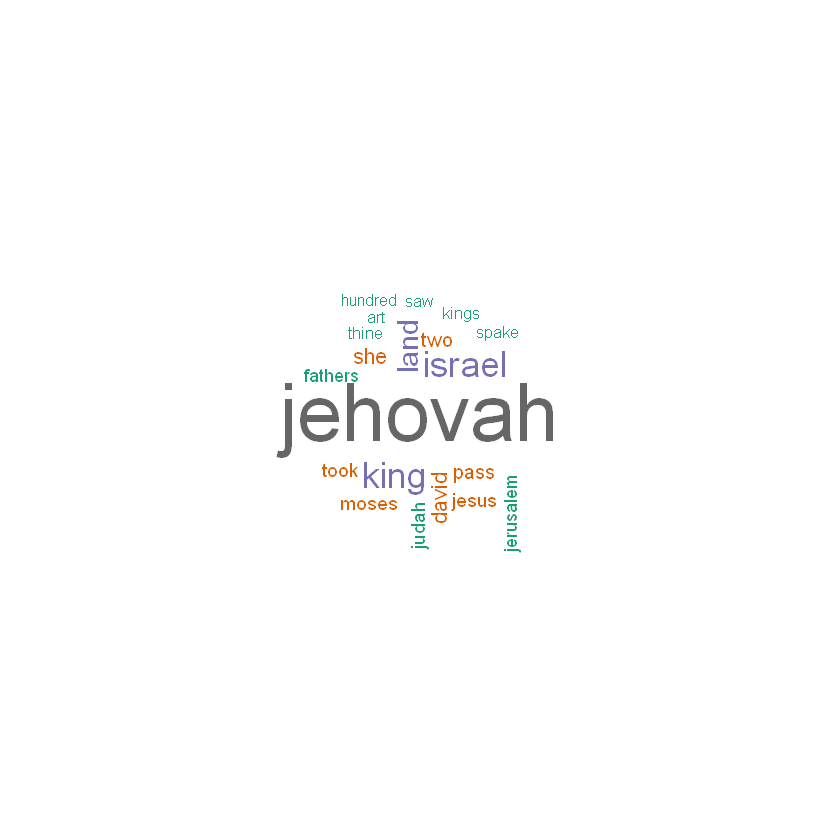

In [137]:
set.seed(129)
wordcloud(names(freq),freq,min.freq=300,max.words = 20,random.order = FALSE,rot.per = .1,
          random.color=TRUE)
wordcloud(names(freq),freq,min.freq=300,max.words = 20,random.order = FALSE,rot.per = .35,
          colors=brewer.pal(8,"Dark2"))

# Seriation:

66 books are ordered based on the following seriation analysis

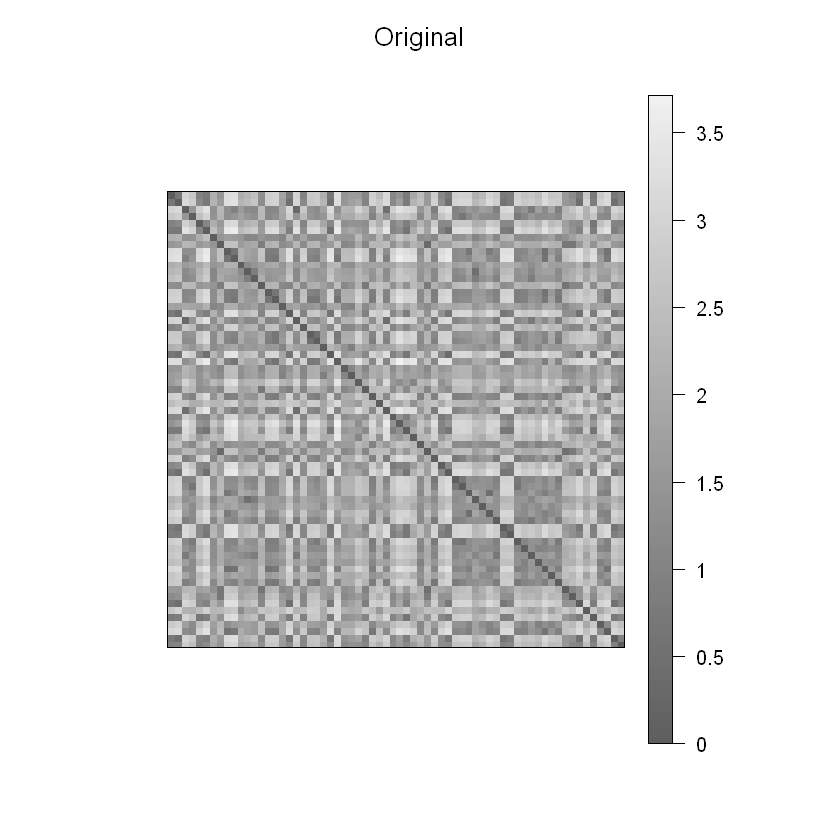

[1] 31 36 28 34 40 33 50 49  1 60 65  2 18 24 41  6 35 62  5 66 20 59  8 38 58
[26] 14 29 26 27 23 17  7 45 12 13 53 48 19  3 32 57 39 42 51 43  4 30 64  9 55
[51] 10 15 16 25 21 22 37 52 54 63 44 47 56 46 11 61

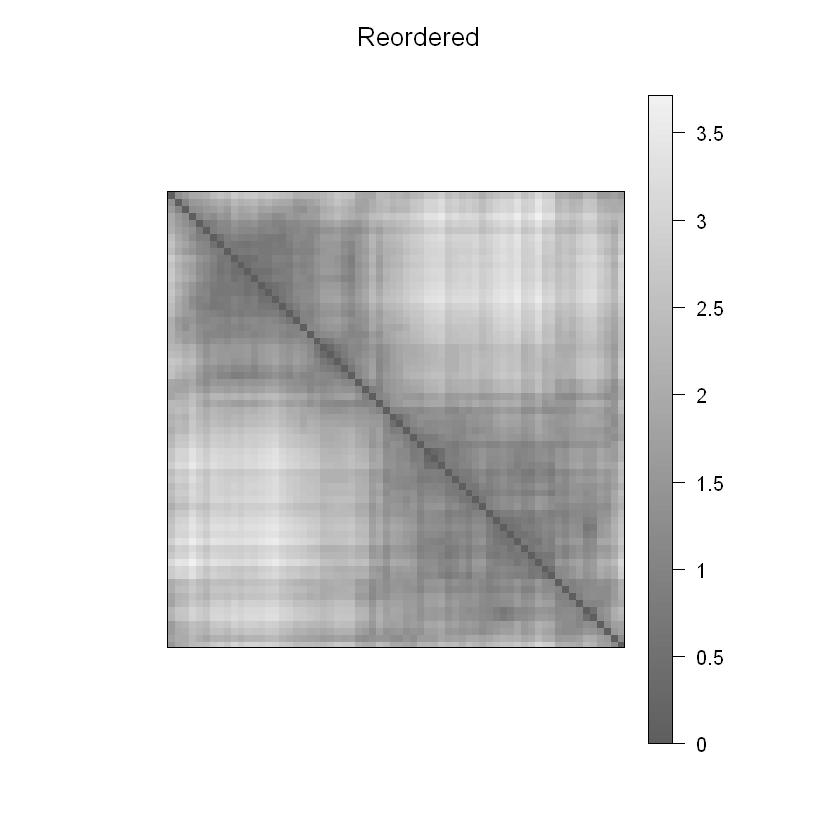

In [139]:
x1<-as.matrix(ASV_cos)
x1<-x1[sample(seq_len(nrow(x1))),]
d1<-dist(x1)
o1<-seriate(d1,method="OLO")
pimage(d1,main="Original")
pimage(d1,o1,main="Reordered")
get_order(o1)

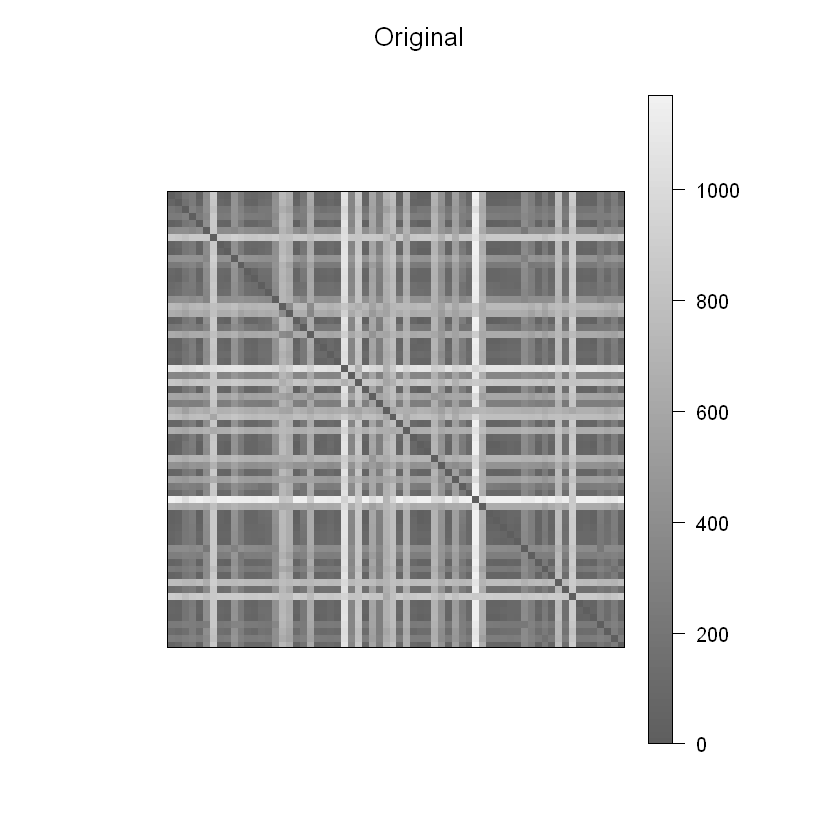

[1] 45 26 28 32 59 33  7 35 27 31 53 11  4 65 55  3 64 24 12 36 23 34 61 13  2
[26] 25 60 22 62 29 47 19 37 48  5  1 38  9 54 41 56  8 49 66 51 50 44 14 15 58
[51] 43 20 63 10 52  6 16 40 42 17 18 21 30 39 46 57

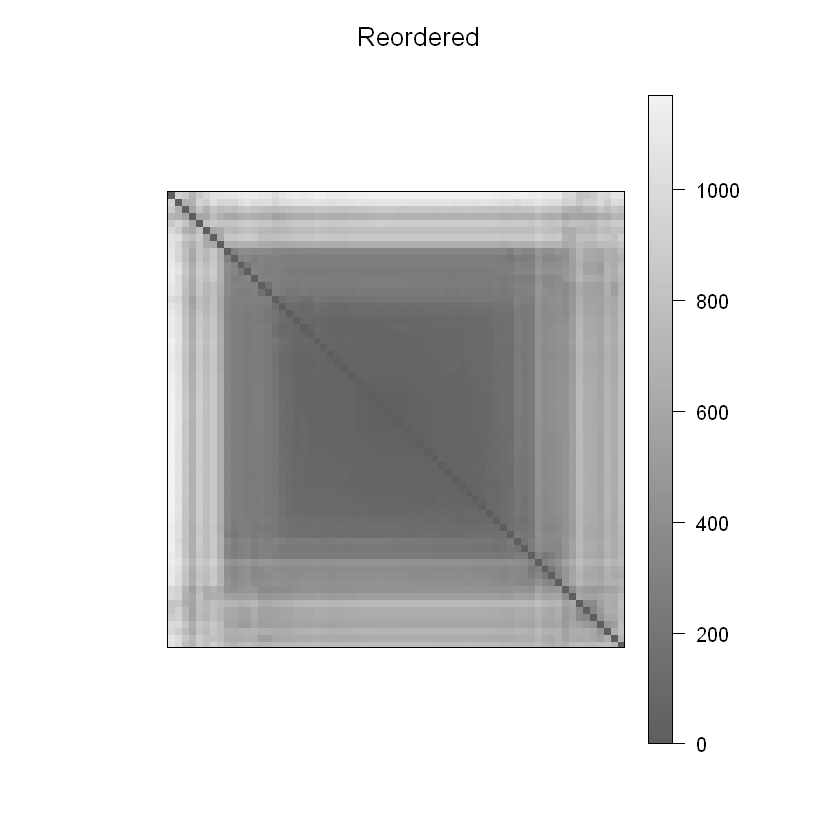

In [141]:
x2<-as.matrix(ASV_dtm)
x2<-x2[sample(seq_len(nrow(x2))),]
d2<-dist(x2)
o2<-seriate(d2,method="OLO")
pimage(d2,main="Original")
pimage(d2,o2,main="Reordered")
get_order(o2)

The ranking generated by the seriation analysis revealed that there is a slight similiarity in the order between the DTM document and the cosine similiarity document.

# Association:

In [142]:
ASV_dsz<-discretizeDF(ASV)
ASV_rules<-apriori(ASV_dsz)
summary(ASV_rules)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 3110 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[63095 item(s), 31103 transaction(s)] done [0.16s].
sorting and recoding items ... [13 item(s)] done [0.01s].
creating transaction tree ... done [0.01s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [65 rule(s)] done [0.00s].
creating S4 object  ... done [0.01s].


set of 65 rules

rule length distribution (lhs + rhs):sizes
 2  3  4 
23 30 12 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   3.000   2.831   3.000   4.000 

summary of quality measures:
    support         confidence      lift           count      
 Min.   :0.1452   Min.   :1    Min.   :1.344   Min.   : 4516  
 1st Qu.:0.1538   1st Qu.:1    1st Qu.:1.344   1st Qu.: 4785  
 Median :0.1881   Median :1    Median :3.000   Median : 5852  
 Mean   :0.2112   Mean   :1    Mean   :2.572   Mean   : 6568  
 3rd Qu.:0.2559   3rd Qu.:1    3rd Qu.:3.000   3rd Qu.: 7958  
 Max.   :0.3333   Max.   :1    Max.   :3.908   Max.   :10368  

mining info:
    data ntransactions support confidence
 ASV_dsz         31103     0.1        0.8

In [144]:
ASV_subr1<-ASV_rules[quality(ASV_rules)$confidence>0.5]
ASV_subr1

set of 65 rules 

Itemsets in Antecedent (LHS)
 [1] "{X=[2.07e+04,3.11e+04],field=[2.6e+07,6.6e+07],Sections=Gospels}"
 [2] "{X=[2.07e+04,3.11e+04],Sections=Gospels}"                        
 [3] "{field=[2.6e+07,6.6e+07],Sections=Gospels}"                      
 [4] "{Sections=Gospels}"                                              
 [5] "{Testaments=OT,Sections=Wisdom}"                                 
 [6] "{X=[1.04e+04,2.07e+04),Testaments=OT}"                           
 [7] "{field=[1.3e+07,2.6e+07),Testaments=OT}"                         
 [8] "{X=[1.04e+04,2.07e+04),Testaments=OT,Sections=Wisdom}"           
 [9] "{field=[1.3e+07,2.6e+07),Testaments=OT,Sections=Wisdom}"         
[10] "{Testaments=NT}"                                                 
[11] "{X=[2.07e+04,3.11e+04]}"                                         
[12] "{field=[2.6e+07,6.6e+07]}"                                       
[13] "{Testaments=NT,Sections=Gospels}"                                
[14] "{Testaments=OT,Sections=Law}"

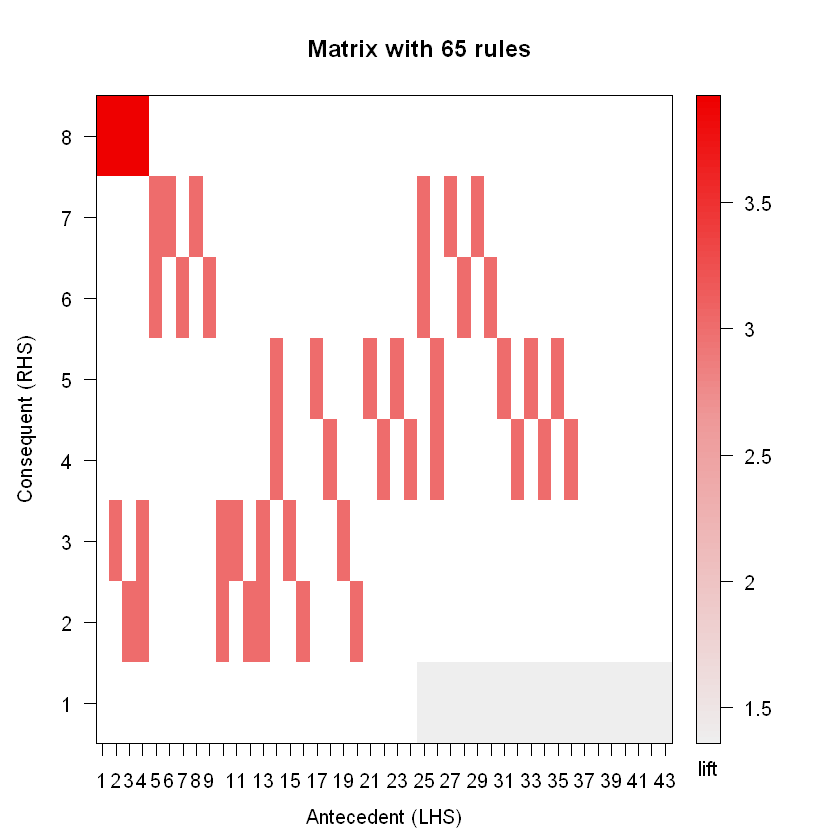

In [145]:
plot(ASV_subr1,method="matrix",measure = "lift")

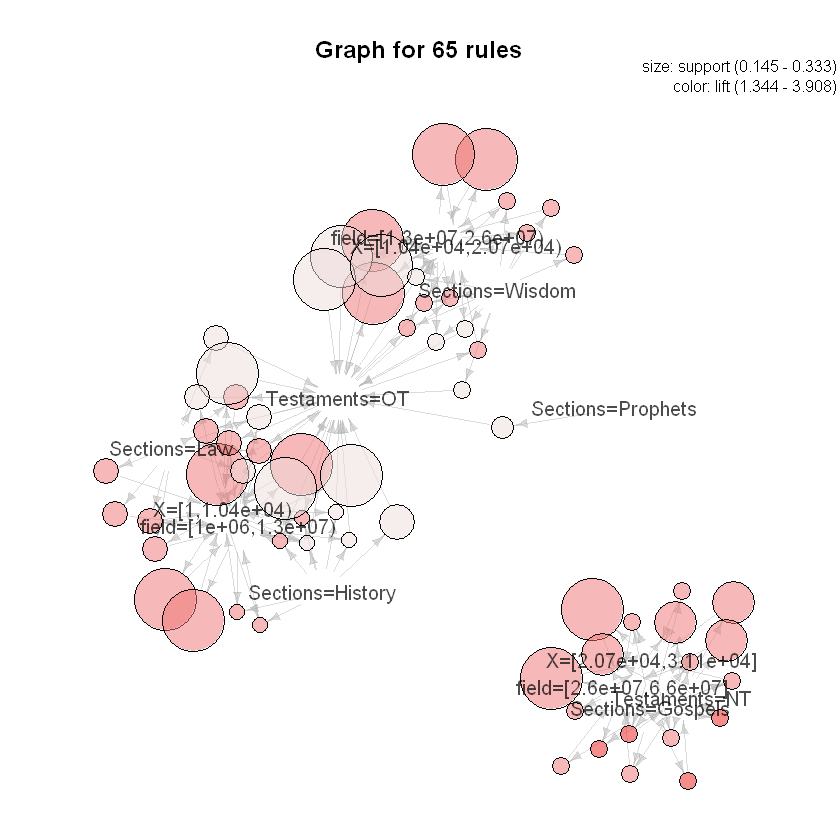

In [146]:
ASV_subr2<-head(sort(ASV_rules,by="lift"),66)
plot(ASV_subr2,method = "graph")

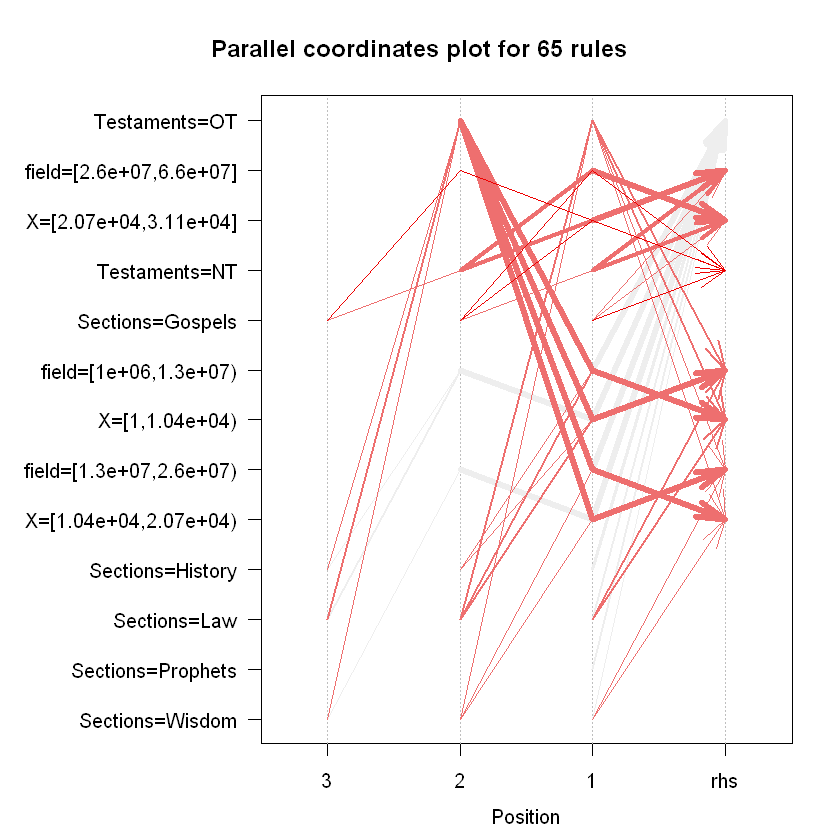

In [147]:
plot(ASV_subr2, method="paracoord")

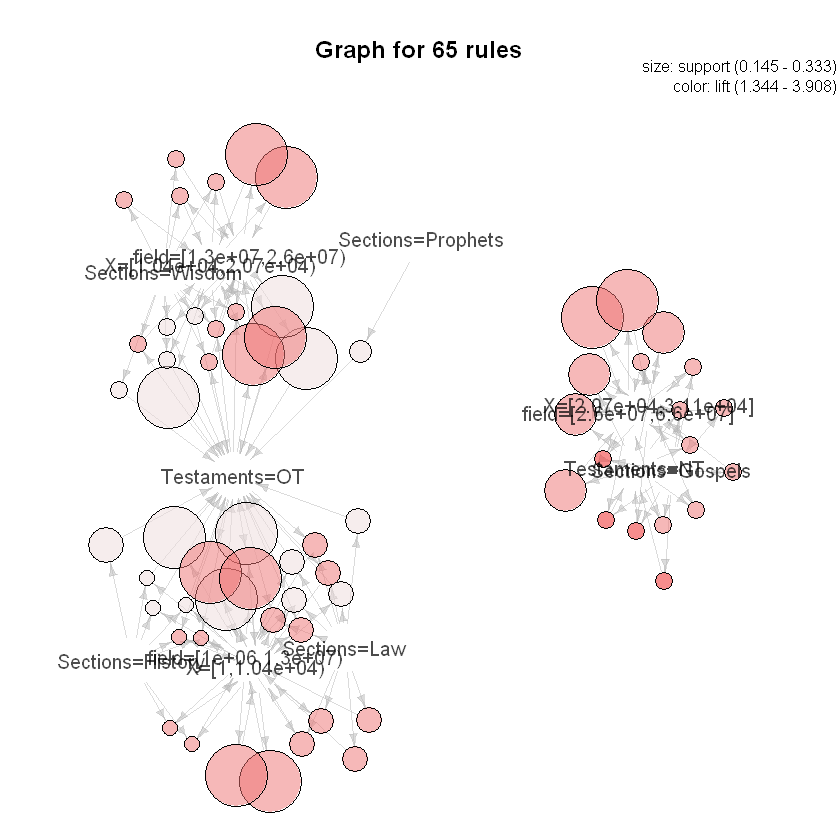

In [148]:
plot(ASV_rules, method="graph")